# **Project description**

The goal of the project is to predict the probability that an online transaction is fraudulent, as denoted by the binary target isFraud.

The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information.

Following the data model:


<a href="https://ibb.co/zfFyDDZ"><img src="https://i.ibb.co/nkBHttj/data-model.png" alt="data-model" border="0"></a>



**Transaction table**

- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:
- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9


**Identity table**

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. 
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features:
- DeviceType
- DeviceInfo
- id_12 - id_38



In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "xxxx"
os.environ['KAGGLE_KEY'] = "xxxxx"

!pip install -q kaggle
!pip install -q kaggle-cli

!kaggle competitions download -c ts1
!unzip for_bw_onecol.csv.zip
!unzip test_data.csv.zip

     |████████████████████████████████| 81kB 6.0MB/s 
     |████████████████████████████████| 5.3MB 8.5MB/s 
     |████████████████████████████████| 133kB 62.6MB/s 
     |████████████████████████████████| 112kB 64.1MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 
 70% 41.0M/58.3M [00:00<00:00, 27.0MB/s]
100% 58.3M/58.3M [00:01<00:00, 57.4MB/s]
 63% 33.0M/52.2M [00:01<00:01, 15.5MB/s]
100% 52.2M/52.2M [00:01<00:00, 33.6MB/s]
  0% 0.00/3.26M [00:00<?, ?B/s]
100% 3.26M/3.26M [00:00<00:00, 108MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 165MB/s]
  0% 0.00/3.21M [00:00<?, ?B/s]
100% 3.21M/3.21M [00:00<00:00, 193MB/s]
Archive:  test_identity.csv.zip
  inflating: test_identity.csv       
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  test_transaction.csv.zip
  inflating: test_transaction.csv    
Archive:  train_identity.csv.zip
  inflating: train_identity.csv      
Archive:  train_transaction.csv.zip
  inflating: train_tr

In [ ]:
!pip install category_encoders

     |████████████████████████████████| 81kB 5.6MB/s 


In [ ]:
from hyperopt import fmin, hp, tpe, Trials, space_eval
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
import scipy.stats as stats
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.decomposition import PCA
plt.style.use('seaborn-whitegrid')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [ ]:
train_identity = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')

test_transaction = pd.read_csv('test_transaction.csv')
test_identity = pd.read_csv('test_identity.csv')

## Optimize memory usage

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
train_identity = reduce_mem_usage(train_identity)
train_transaction = reduce_mem_usage(train_transaction)
test_transaction = reduce_mem_usage(test_transaction)
test_identity = reduce_mem_usage(test_identity)

Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)


- How much data have we got?
- Are there any missing values? 
- Is the classification problem balanced?
- Are there any outliers? 

----- Training datasets -------
-> Transaction table: 590540 rows and 394 columns
-> Identity table: 144233 rows and 41 columns

----- Test datasets -------
-> Transaction table: 506691 rows and 393 columns
-> Identity table: 141907 rows and 41 columns


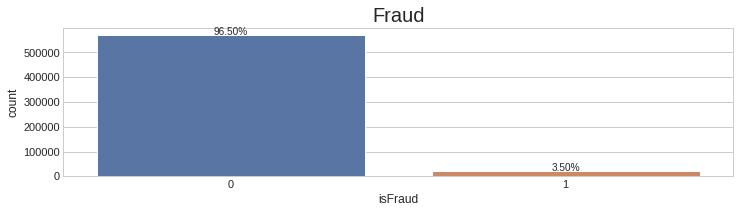

In [ ]:
print('----- Training datasets -------')
print(f'-> Transaction table: {train_transaction.shape[0]} rows and {train_transaction.shape[1]} columns')
print(f'-> Identity table: {train_identity.shape[0]} rows and {train_identity.shape[1]} columns')

print('\n----- Test datasets -------')
print(f'-> Transaction table: {test_transaction.shape[0]} rows and {test_transaction.shape[1]} columns')
print(f'-> Identity table: {test_identity.shape[0]} rows and {test_identity.shape[1]} columns')

title = 'Fraud'
total = len(train_transaction)

plt.figure(figsize=(12,6))

feature = train_transaction.isFraud

ax = plt.subplot(2,1,1)
sns.countplot(feature)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+3000,
            f'{height/total:.2%}',
            ha="center", fontsize=10)

ax.set_title(title,fontsize=20)
plt.show()

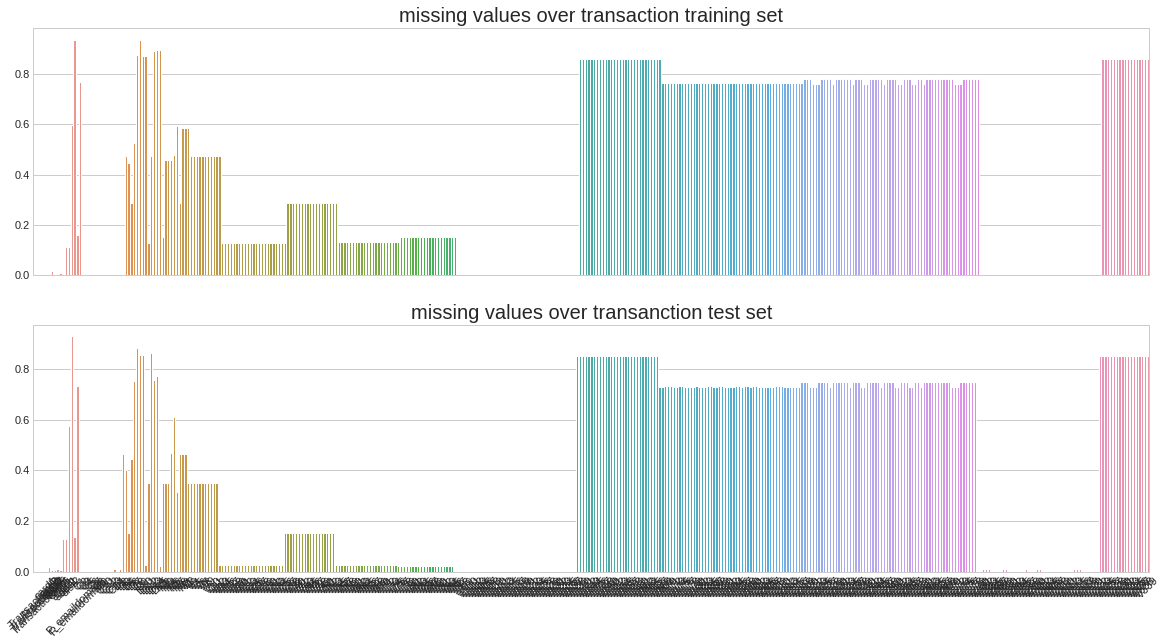

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(20)
sns.barplot(train_transaction.isna().sum().index, train_transaction.isna().sum()/len(train_transaction), ax=ax1)
ax1.set_title('missing values over transaction training set',fontsize=20)
plt.xticks(rotation=45)

sns.barplot(test_transaction.isna().sum().index, test_transaction.isna().sum()/len(test_transaction),  ax=ax2)
ax2.set_title('missing values over transanction test set',fontsize=20)
plt.show()

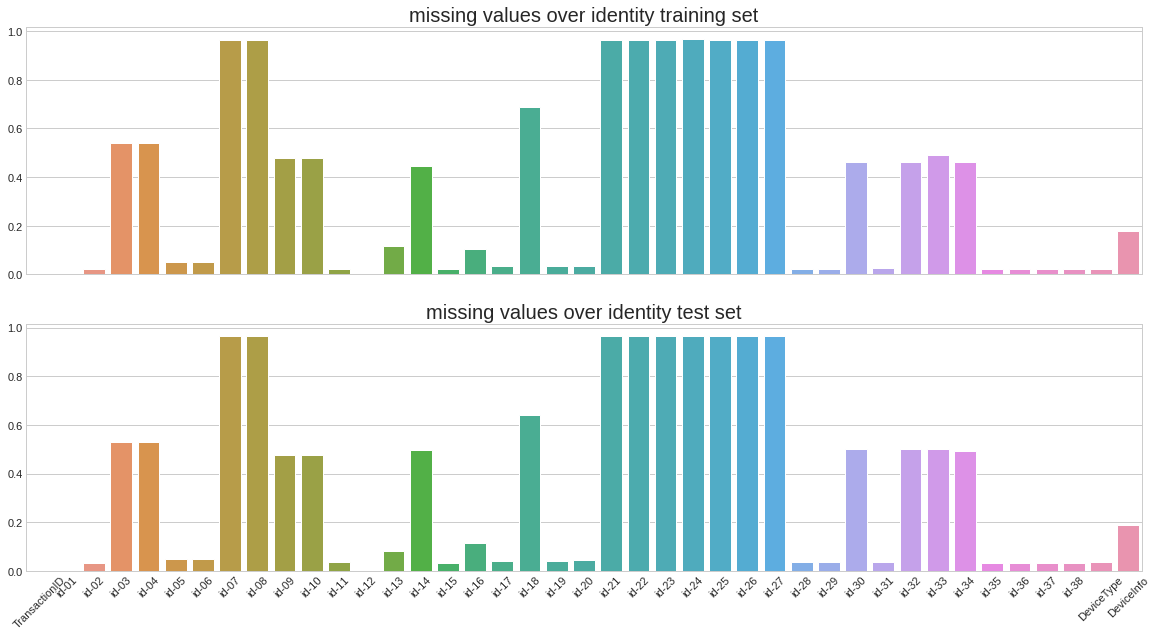

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(20)
sns.barplot(train_identity.isna().sum().index, train_identity.isna().sum()/len(train_identity), ax=ax1)
ax1.set_title('missing values over identity training set',fontsize=20)
plt.xticks(rotation=45)

sns.barplot(test_identity.isna().sum().index, test_identity.isna().sum()/len(test_identity),  ax=ax2)
ax2.set_title('missing values over identity test set',fontsize=20)
plt.show()

- Xlabel is not visible, but we can clearly see that many features share the same proportion of missing values. 
- Many features are composed of more than 80% of missing values.
- same missing values patterns are appearing in test data that means that we should pay close attention to how we deal with these missing values.

Could be interesting to check if missing values are located in the very same samples if so then this a great indicator that data is not missing at random

In [ ]:
nan_proportion = {}

def ratio_nan(feature):
    return feature.isna().sum()/feature.shape[0]

for column, serie in train_transaction.iteritems():
    prop = ratio_nan(serie)
    if prop in nan_proportion.keys():
        nan_proportion[prop].append(column)
    else:
        nan_proportion[prop] = [column]

In [ ]:
nan_proportion

features v12 up to v34 are composed of the same amount of missing values which is 12,88%. Lets check if these missing values are concentrated over the same samples. For this lets plot a heatmap of the missing values over the training set and features V12 up to V34.

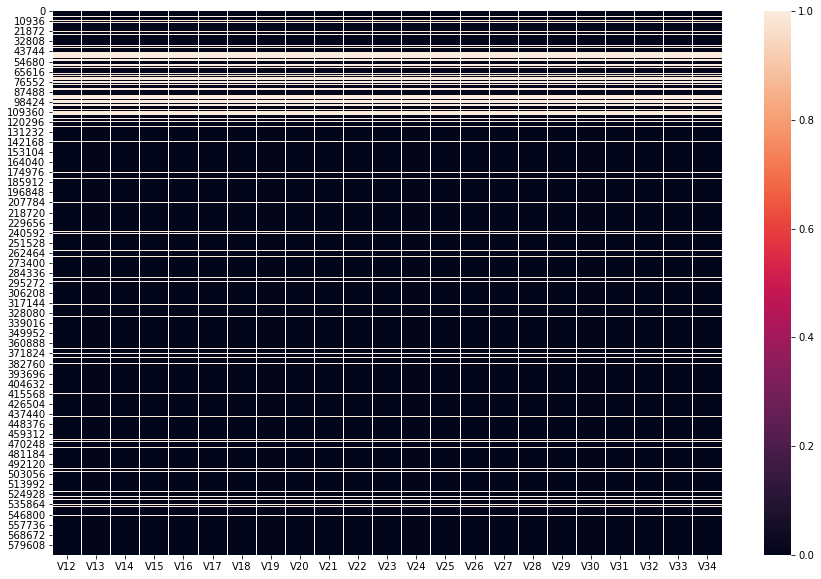

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(train_transaction[nan_proportion[0.1288193856470349]].isnull())
plt.show()

Our inuition was good we can clearly see that the missing values are distrubted over the very same samples

# Numerical variables

- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- dist1 & dist2 : distance
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.


## TransactionDT
timedelta from a given reference datetime (not an actual timestamp)

In [ ]:
train_transaction.TransactionDT.isna().sum()

0

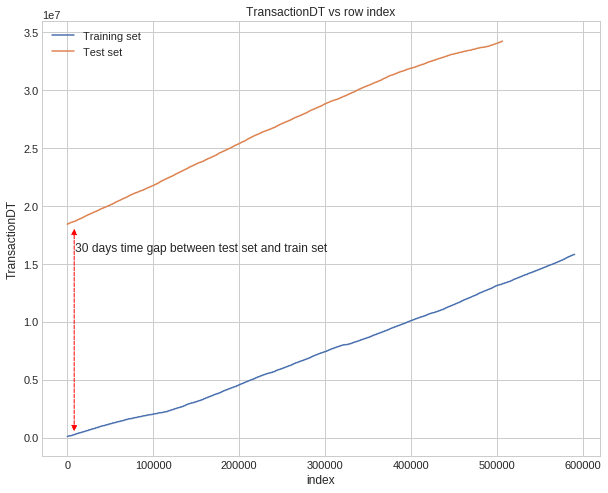

In [ ]:
with plt.style.context('_classic_test_patch'):
  plt.figure(figsize=(10,8))
  ax = plt.axes()
  ax.plot(range(len(train_transaction)), train_transaction.TransactionDT, label='Training set')
  ax.plot(range(len(test_transaction)), test_transaction.TransactionDT, label='Test set')
  ax.set_xlabel('index')
  ax.set_ylabel('TransactionDT')
  ax.set_title('TransactionDT vs row index')
  time_gap = int((test_transaction.TransactionDT.iloc[0] - train_transaction.TransactionDT.iloc[-1])/(3600*24))
  ax.annotate(f'{time_gap} days time gap between test set and train set', xy=(7.4, 1.6e7), xycoords='data', ha='left',
              xytext=(7.4, .8), textcoords='offset points')
  ax.annotate('', xy=(.8e4, 0.036e7), xytext=(.8e4, 1.82e7),
              xycoords='data', textcoords='data',
              arrowprops={'arrowstyle': '<|-|>','color':'red', 'ls':'--'})

  plt.legend()
  plt.show()

- Both training and test set are sorted by TransactionDT. 
- There is a gap between TransactionDT in test and train set. Since TransactionDT is somehow related to time, intuitevely I would say that the organizers have used a time-based split we shoud then pay attention when we evaluate the skill of our model using cross-validation. 

> **We might want to use time based split in order to mimic the split strategy used by organizers.**
> 
- TransactionDT seems to be expressed in seconds.

Let's study the impact of time on fraud, let's look at the daily patterns and find out if fraud is more likely to happen in some time slots.

24hours is equivalent to 86400seconds

isFraud            0     1  fraud proportion
TransactionDT                               
0              36609  1186              3.14
1              31770  1027              3.13
2              25730  1002              3.75
3              20005   797              3.83
4              14069   770              5.19
5               9019   682              7.03
6               5540   467              7.77
7               3311   393             10.61
8               2350   241              9.30
9               2256   223              9.00
10              3434   193              5.32
11              6562   265              3.88
12             12072   379              3.04
13             19850   465              2.29
14             27642   686              2.42
15             32999   860              2.54
16             37556  1142              2.95
17             39439  1284              3.15
18             40172  1467              3.52
19             40652  1463              3.47
20             40350  1432              3.43
21             40225  1416              3.40
22             39794  1345              3.27
23             38471  1478              3.70

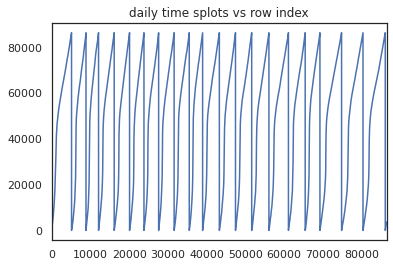

In [ ]:
tr_dt = (train_transaction.TransactionDT)%86400
plt.plot(tr_dt.index, tr_dt.values)
plt.title('daily time splots vs row index')
plt.xlim((0,86400))
tr_dt_cat = pd.cut(tr_dt, 24, right=True, labels=range(24))
ct = pd.crosstab(tr_dt_cat, train_transaction.isFraud)
ct['fraud proportion'] = round(100*(ct.iloc[:,1]/(ct.iloc[:,0]+ct.iloc[:,1])),2)
ct

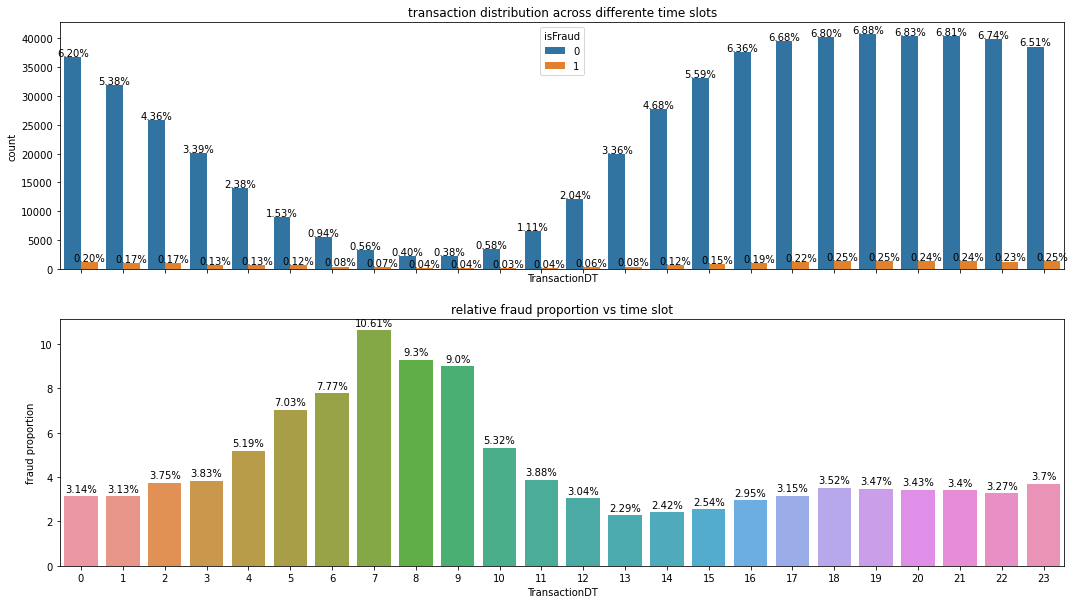

In [ ]:
fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
total = len(train_transaction)
sns.countplot(tr_dt_cat, hue=train_transaction.isFraud, ax=ax)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+200,
            f'{height/total:.2%}',
            ha="center", fontsize=10)
ax.set_title('transaction distribution across differente time slots')
sns.barplot(ct.index, ct['fraud proportion'], ax=ax1)
ax1.set_title('relative fraud proportion vs time slot')

for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x()+p.get_width()/2.,
            height+.2,
            f'{height}%',
            ha="center", fontsize=10)    

plt.show()

we can see that time slot from 6 to 7 has recorded 10.61% of fraud which represents 0.07% of the total amount of transactions recorded in the dataset

## TransactionAMT

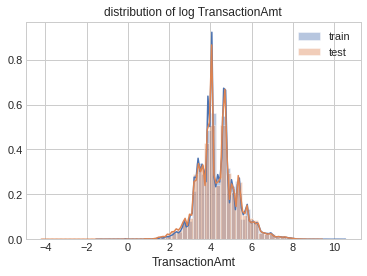

In [ ]:
plt.figure()
sns.distplot(np.log(train_transaction.TransactionAmt), label='train')
sns.distplot(np.log(test_transaction.TransactionAmt), label='test')
plt.title('distribution of log TransactionAmt')
plt.legend()
plt.show()

TransactionAmt has the same shape in train as well as in test.

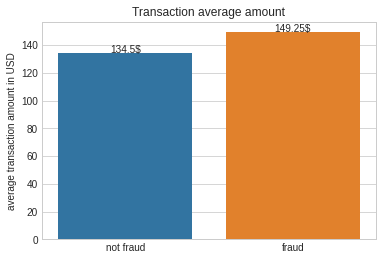

In [ ]:
plt.figure()
ax1 = plt.axes()
plt.title('Transaction average amount')
sns.barplot(x = ['not fraud', 'fraud'], y=train_transaction.groupby('isFraud').TransactionAmt.mean().values)
plt.ylabel('average transaction amount in USD')

for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x()+p.get_width()/2.,
            height+.2,
            f'{height}$',
            ha="center", fontsize=10)
    
plt.show()

Fraudulent transactions amount are in average ~11% higher than none fraudulent transactions



## dist1 & dist2

distance metric

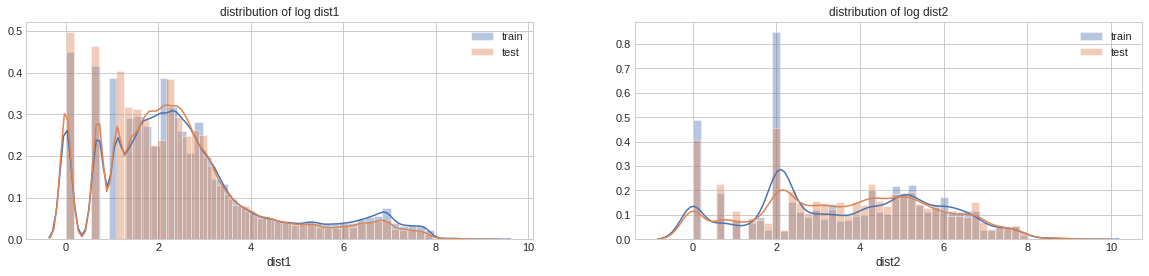

In [ ]:
plt.figure(figsize=(20,4))
plt.style.use('seaborn-whitegrid')

plt.subplot(1,2,1)
sns.distplot(np.log(train_transaction.dist1+1), label='train')
sns.distplot(np.log(test_transaction.dist1+1), label='test')
plt.title('distribution of log dist1')
plt.legend()

plt.subplot(1,2,2)
sns.distplot(np.log(train_transaction.dist2+1), label='train')
sns.distplot(np.log(test_transaction.dist2+1), label='test')
plt.title('distribution of log dist2')
plt.legend()

plt.show()

We should also note the number of unique values for dist1 & dist2 in train set. We have 2651 unique values for dist1 and dist2 has 1751 unique values. Should we treat these variables as ordinal variables?


In [ ]:
train_transaction.dist1.nunique(), train_transaction.dist2.nunique()

(2651, 1751)

## Addr1 & addr2

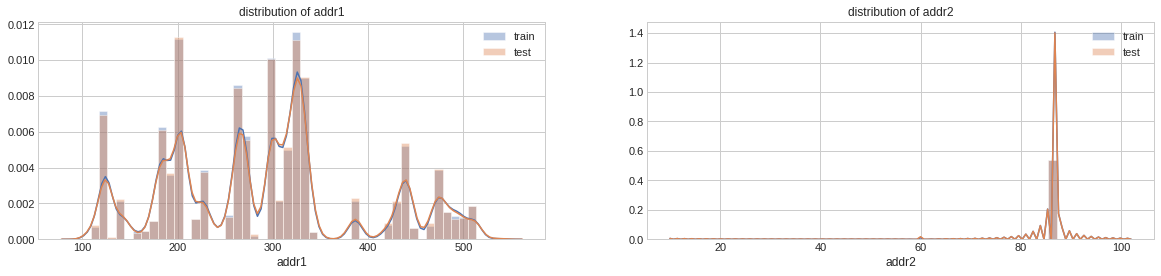

In [ ]:
plt.figure(figsize=(20,4))

plt.subplot(1,2,1)
sns.distplot(train_transaction.addr1, label='train')
sns.distplot(test_transaction.addr1, label='test')
plt.title('distribution of addr1')
plt.legend()

plt.subplot(1,2,2)
sns.distplot(train_transaction.addr2, label='train')
sns.distplot(test_transaction.addr2, label='test')
plt.title('distribution of addr2')
plt.legend()

plt.show()

In [ ]:
train_transaction.addr1.nunique(), train_transaction.addr2.nunique()

(332, 74)

In [ ]:
# which region has more fraud
addr = train_transaction.groupby(['addr1', 'addr2'])[['isFraud']].count().reset_index()
addr['addr1_addr2'] = addr.addr1.astype(str) + '_' + addr.addr2.astype(str)
addr['Fraud_count'] = addr['isFraud']
addr.sort_values(by='Fraud_count')


addr1  addr2  isFraud  addr1_addr2  Fraud_count
218  296.0   89.0        1   296.0_89.0            1
115  232.0   87.0        1   232.0_87.0            1
116  233.0  101.0        1  233.0_101.0            1
117  234.0   87.0        1   234.0_87.0            1
118  235.0   31.0        1   235.0_31.0            1
..     ...    ...      ...          ...          ...
267  330.0   87.0    26284   330.0_87.0        26284
144  264.0   87.0    39870   264.0_87.0        39870
92   204.0   87.0    42018   204.0_87.0        42018
258  325.0   87.0    42748   325.0_87.0        42748
232  299.0   87.0    46324   299.0_87.0        46324

[437 rows x 5 columns]

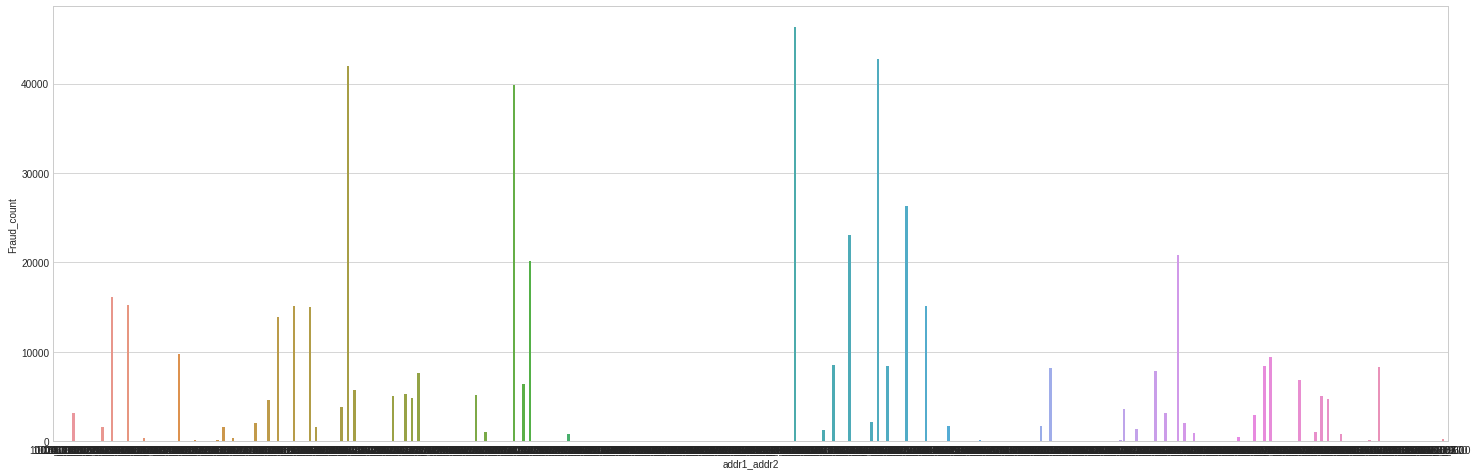

In [ ]:
plt.figure(figsize=(25,8))
sns.barplot(x=addr.addr1_addr2, y=addr.Fraud_count)
plt.show()

In [ ]:
# todo user multi indexing from pandas to understand better data
# https://scentellegher.github.io/programming/2017/07/15/pandas-groupby-multiple-columns-plot.html

## C1-C14
counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

In [ ]:
cxx = [col for col in train_transaction.columns if col.startswith('C')]

<Figure size 432x288 with 0 Axes>

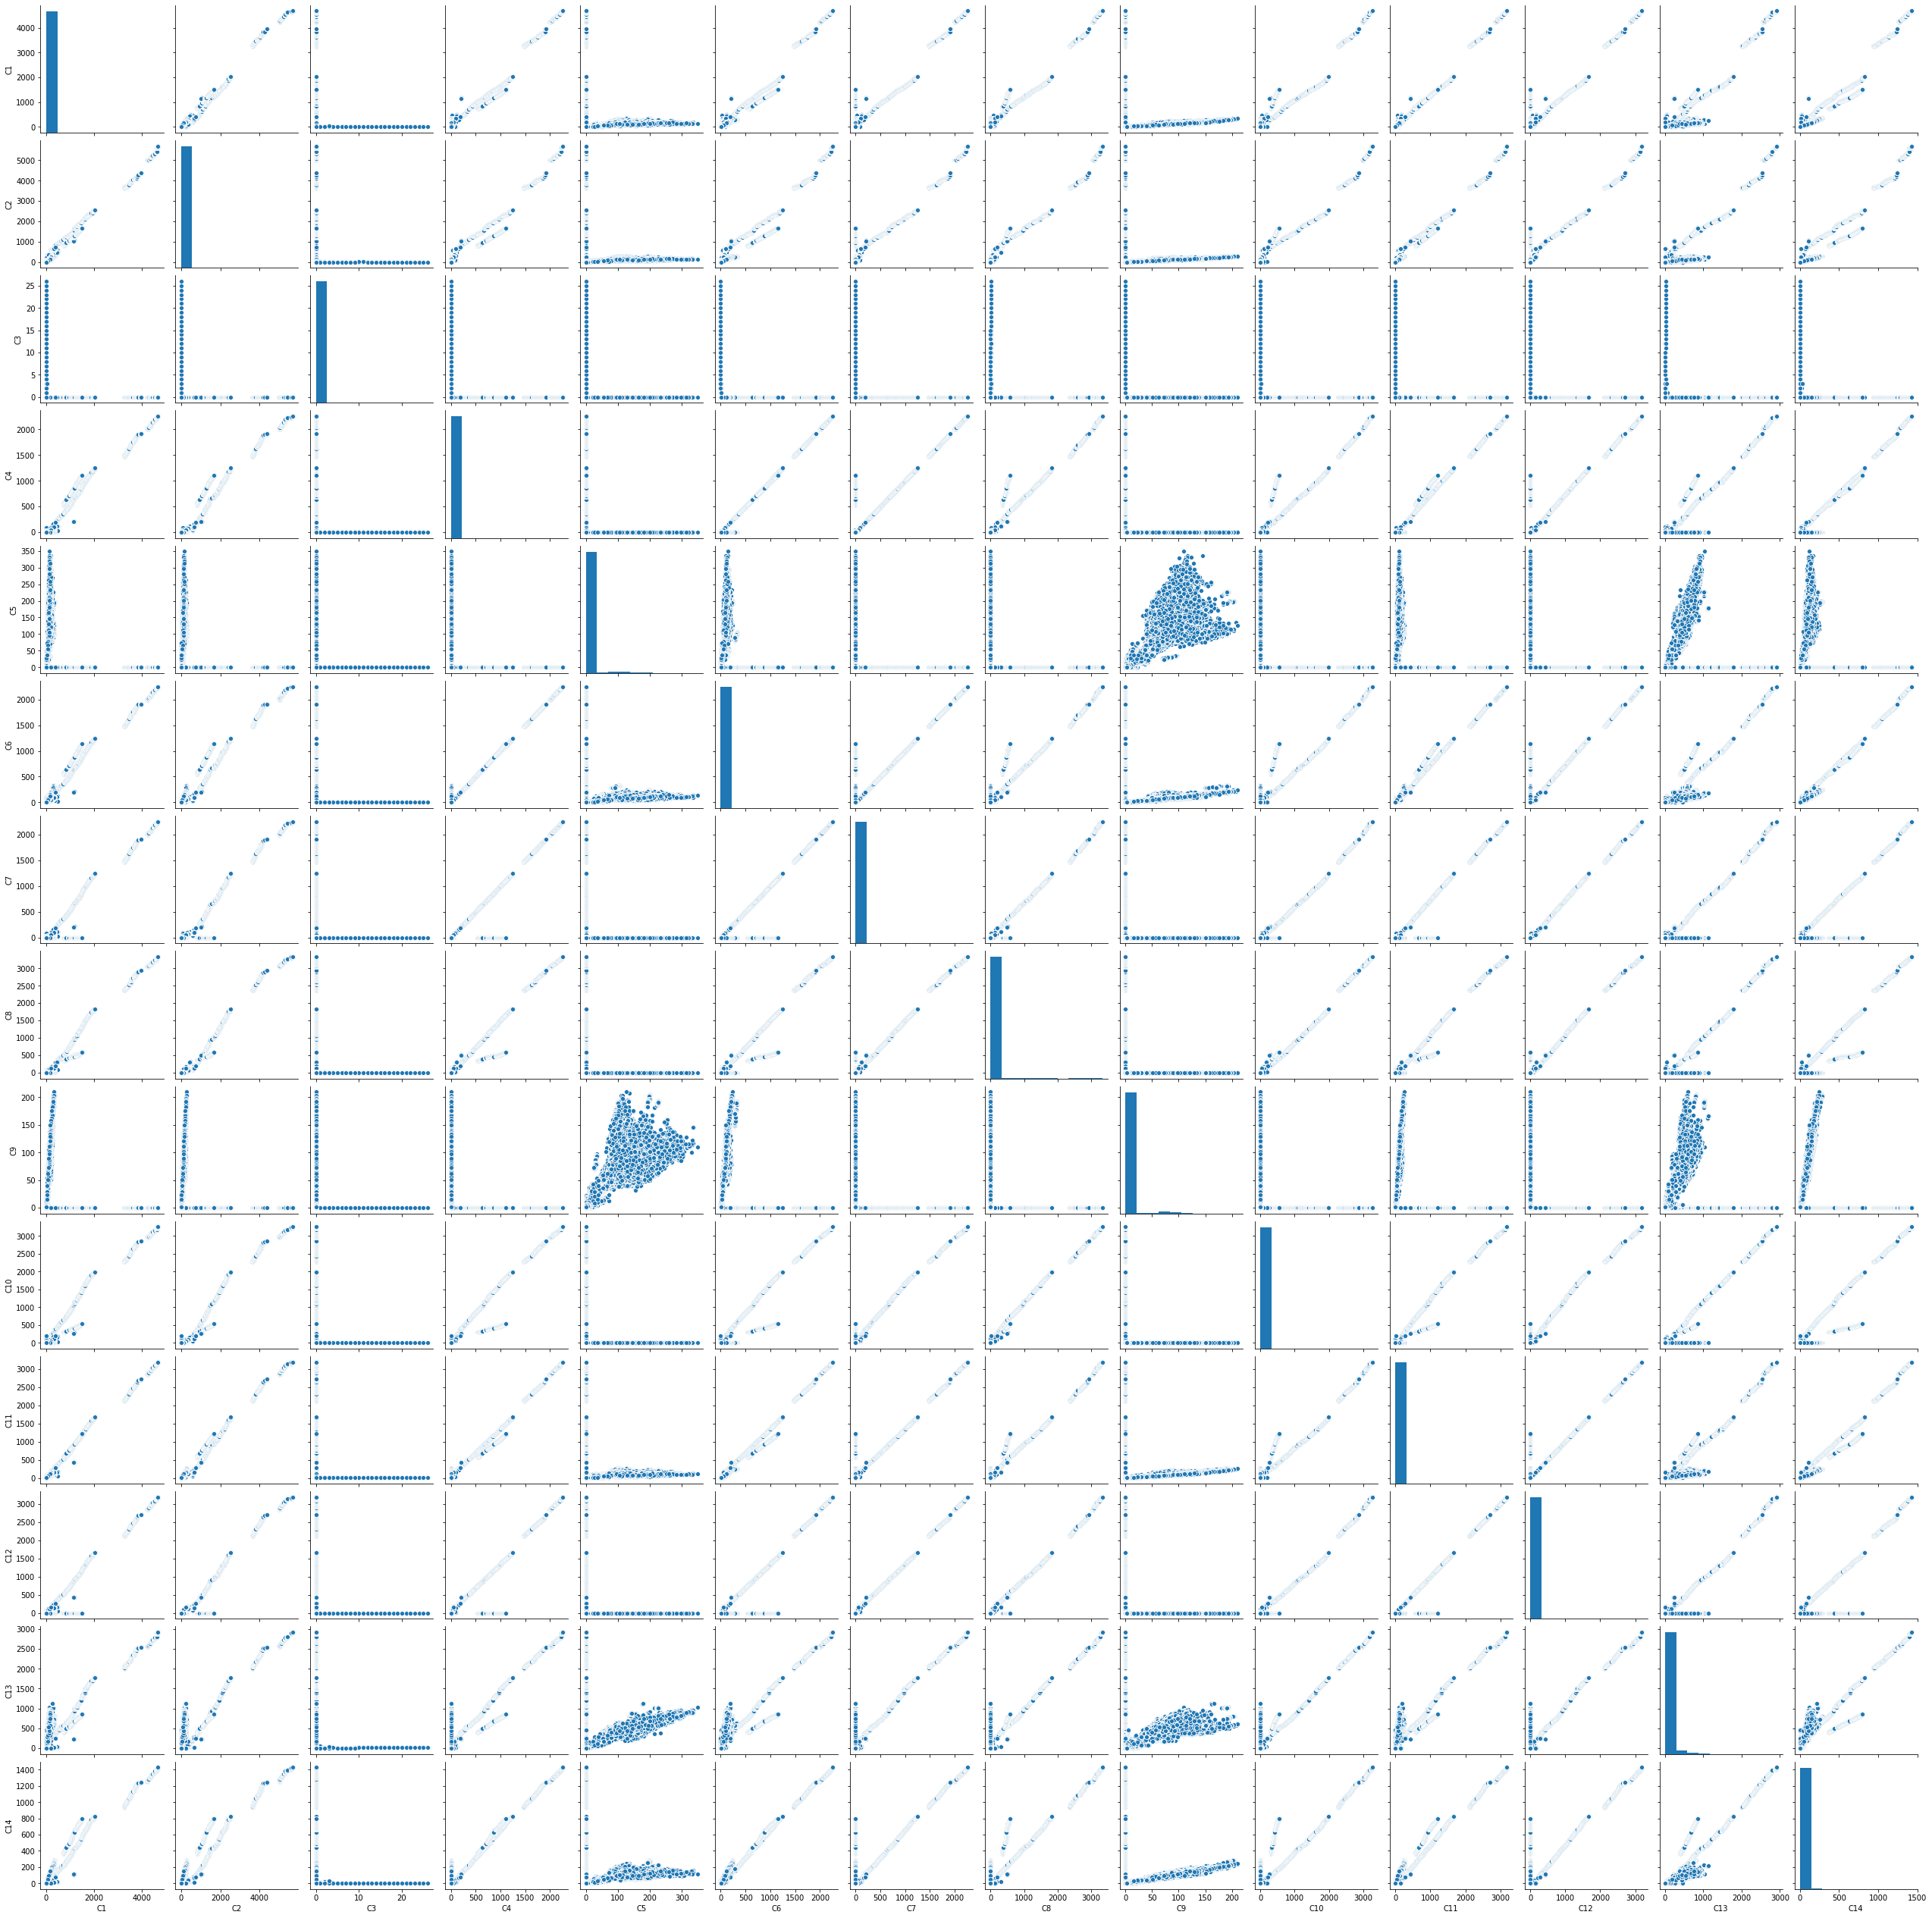

In [ ]:
plt.figure()
sns.pairplot(train_transaction[cxx])
plt.show()

In [ ]:
def plot_corr_matrix(df):
    
    sns.set(style="white")

    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15,10))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

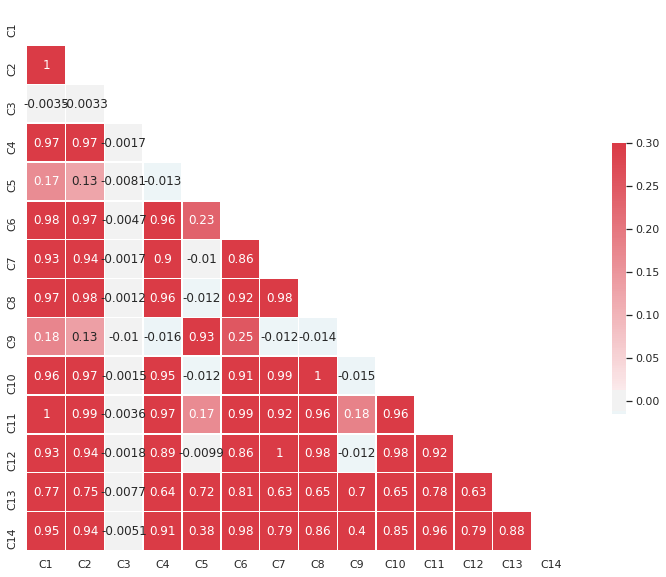

In [ ]:
plot_corr_matrix(train_transaction[cxx])

We can see from the pair plot that cxx features are highly correlated and this is confirmed by correlation matrix above

## V1-V339

In [ ]:
vxx = [col for col in train_transaction.columns if col.startswith('V')]

In [ ]:
def get_corr_pairs(df, thresh=0.8):
    corr_ = df.corr()
    corr_ = corr_.apply(np.abs)
    
    # get only upper part of correlation matrix to avoid having duplicate pairs
    mask = np.triu(np.ones_like(corr_, dtype=np.bool))
    np.fill_diagonal(mask, 0)
    mask_df = pd.DataFrame(mask, columns=corr_.columns, index=corr_.columns)
    corr_ = corr_[mask_df].fillna(value=0)
    
    # iterate and compute duplicate pairs
    corr_pair = []
    for column, serie in corr_.iteritems():
        for index, value in serie.iteritems():
            if value>thresh:
                corr_pair.append((index, column))
                
    return corr_pair

In [ ]:
vxx_corr_pairs = get_corr_pairs(train_transaction[vxx])

In [ ]:
len(vxx_corr_pairs)

2519

Vxx are also highly correlated, 2519 correlated pairs with more than 80% correlation

## D1-D15
timedelta, such as days between previous transaction, etc.

In [ ]:
dxx = [col for col in train_transaction.columns if col.startswith('D')]

<Figure size 432x288 with 0 Axes>

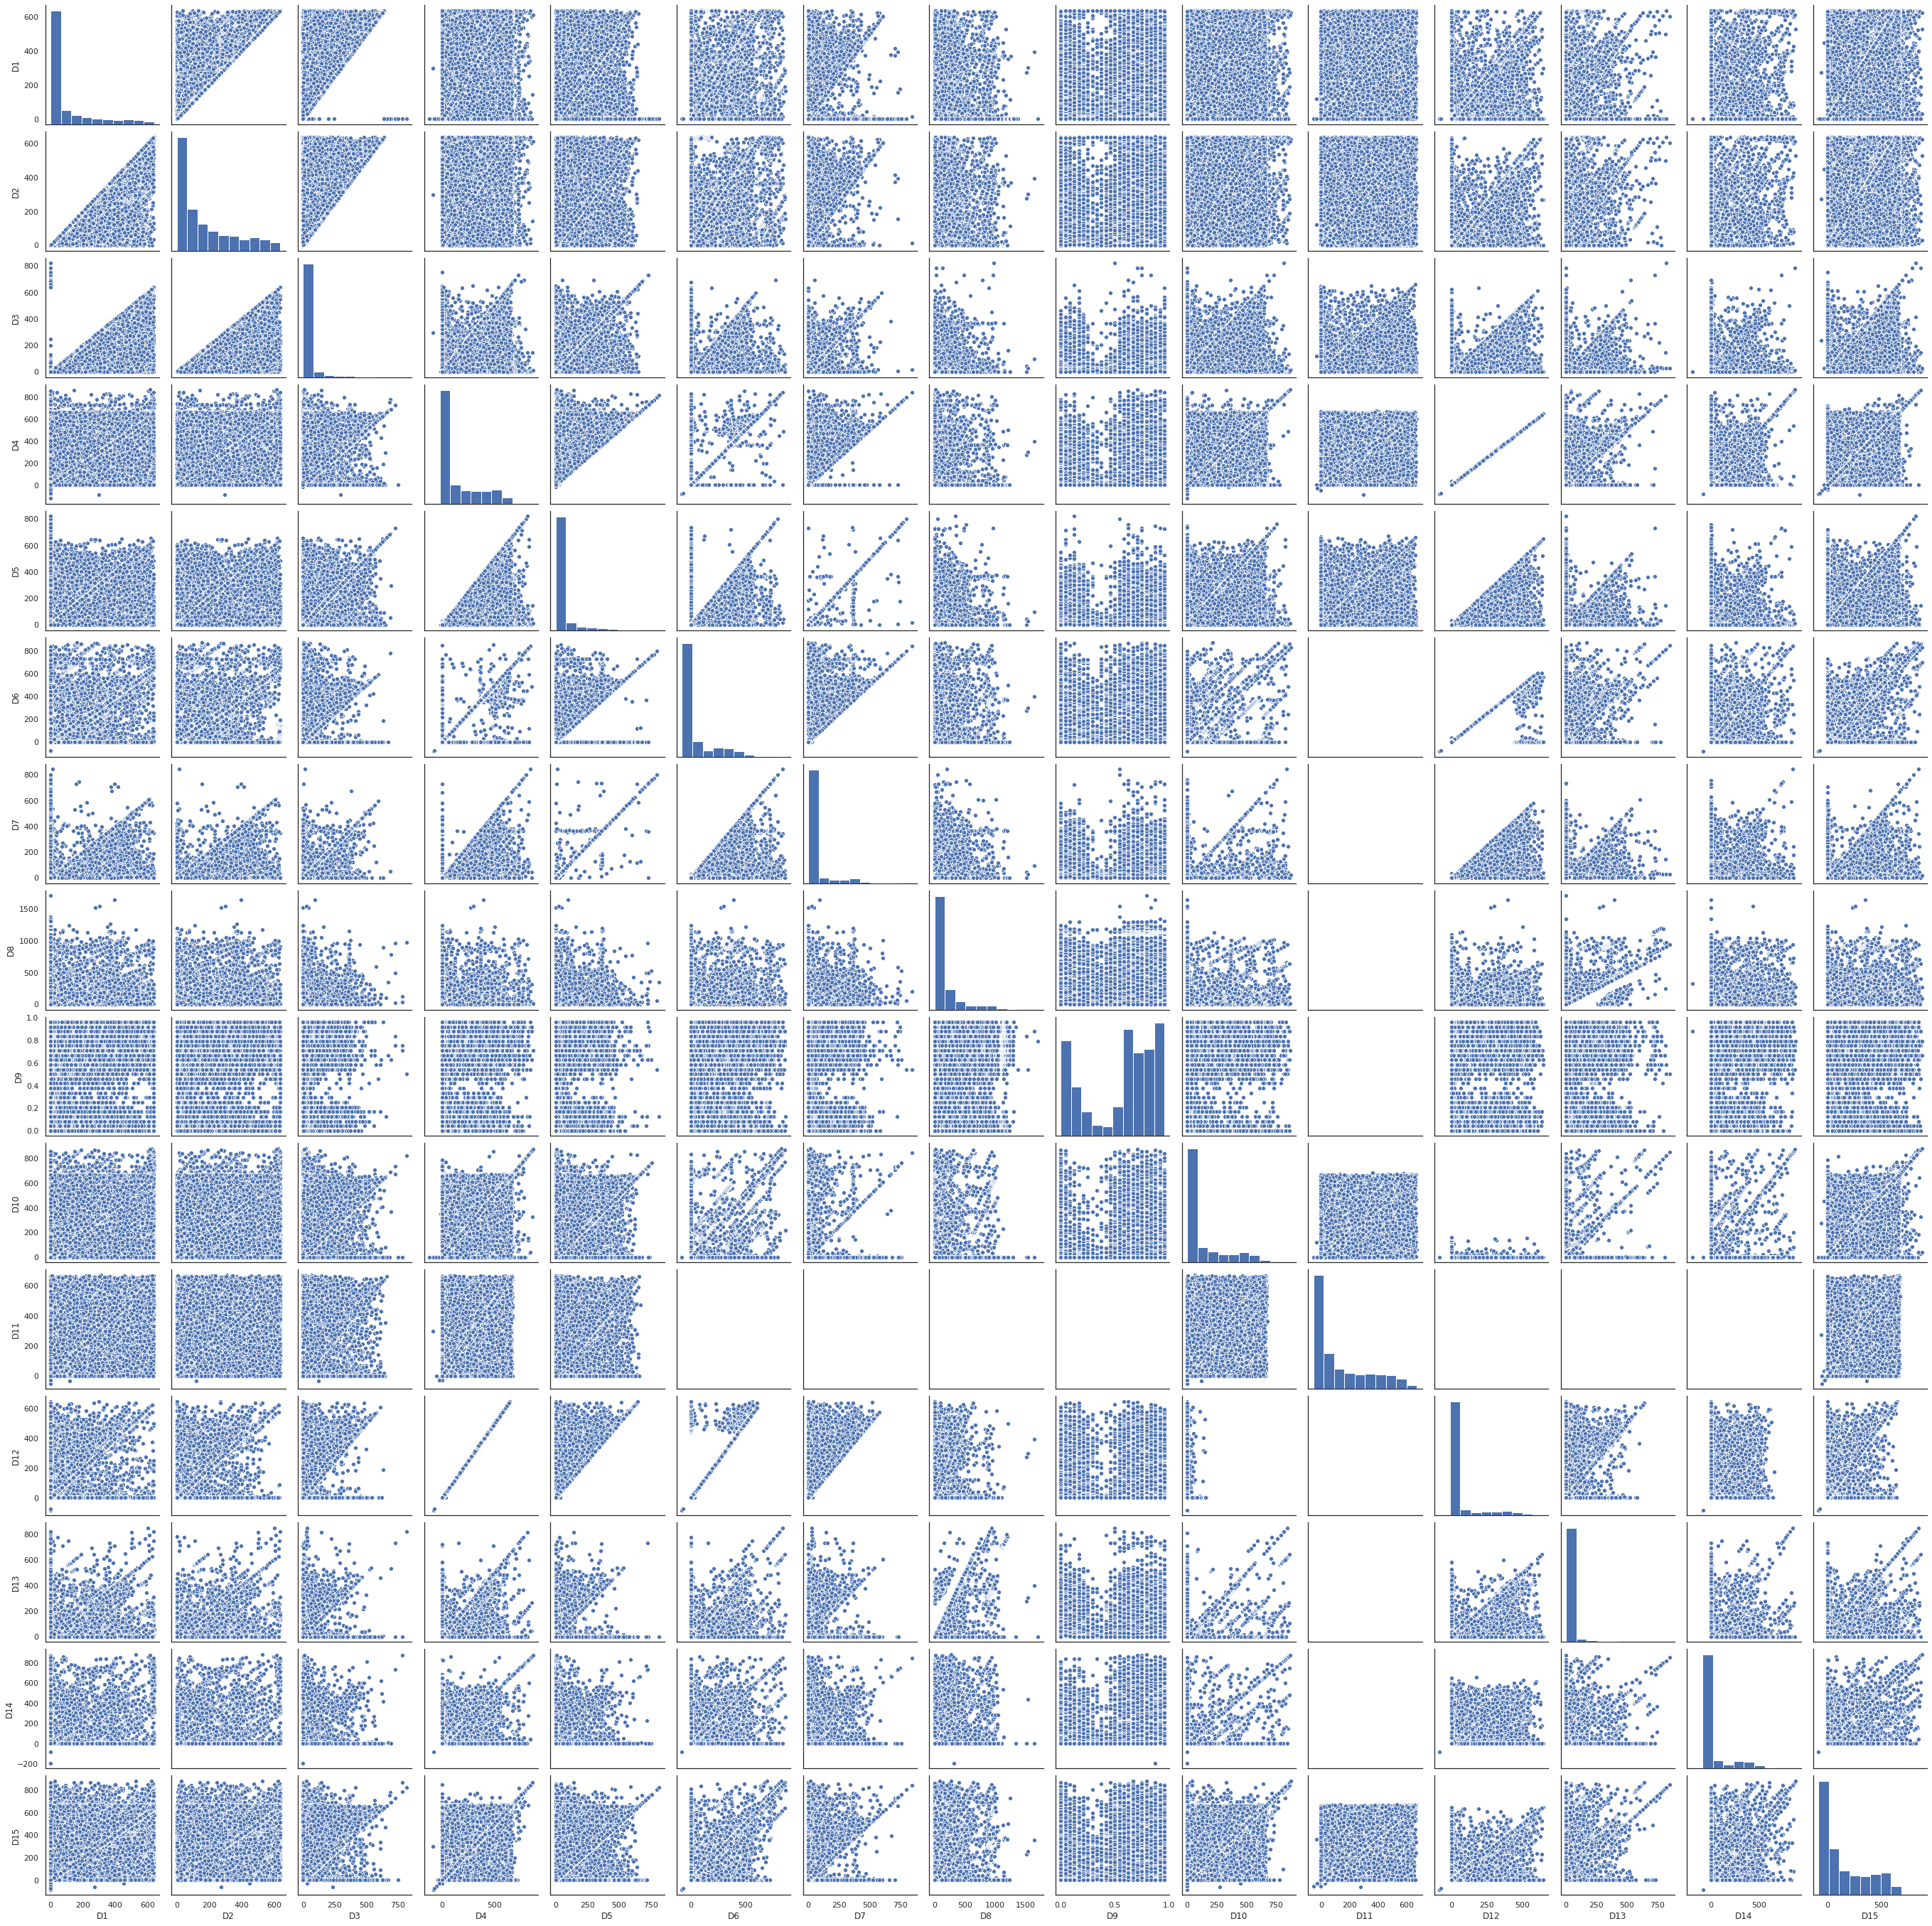

In [ ]:
plt.figure()
sns.pairplot(train_transaction[dxx])
plt.show()

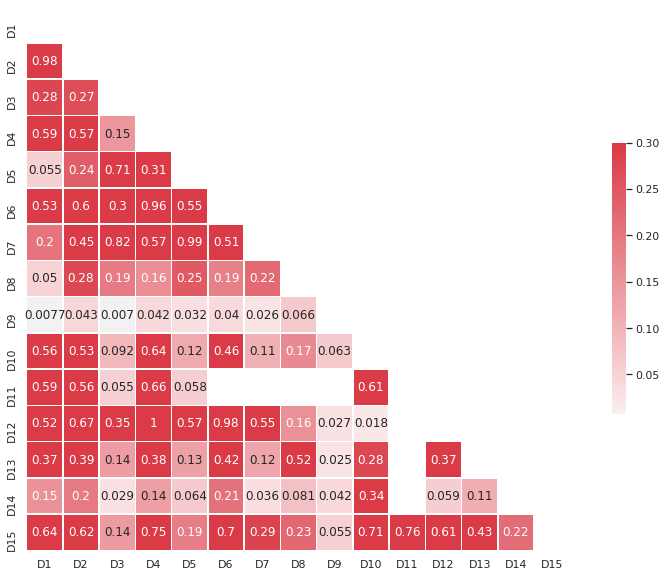

In [ ]:
plot_corr_matrix(train_transaction[dxx])

# Categorical features

## ProductCD
Product code, the product for each transaction

In [ ]:
ct = pd.crosstab(train_transaction.ProductCD, train_transaction.isFraud)
ct['relative fraud proportion'] = round(100*(ct.iloc[:,1]/(ct.iloc[:,0]+ct.iloc[:,1])),2)
ct

isFraud         0     1  relative fraud proportion
ProductCD                                         
C           60511  8008                      11.69
H           31450  1574                       4.77
R           36273  1426                       3.78
S           10942   686                       5.90
W          430701  8969                       2.04

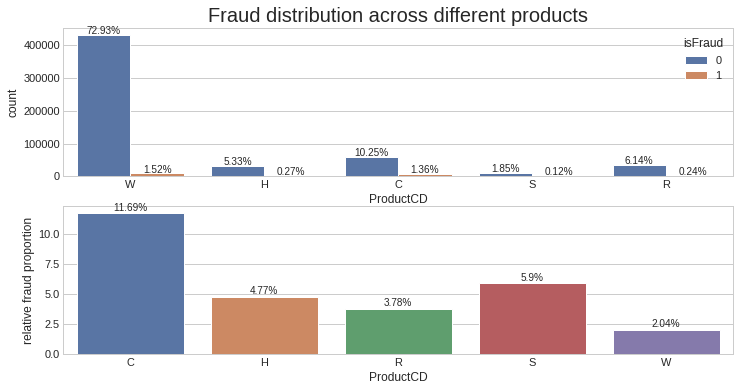

In [ ]:
ProductCD_count = train_transaction.ProductCD.value_counts()

plt.figure(figsize=(12,6))

total = len(train_transaction)

ax = plt.subplot(2,1,1)
sns.countplot(train_transaction.ProductCD, hue=train_transaction.isFraud)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+3000,
            f'{height/total:.2%}',
            ha="center", fontsize=10)

ax.set_title('Fraud distribution across different products',fontsize=20)
ax1 = plt.subplot(2,1,2)
sns.barplot(ct.index, ct['relative fraud proportion'])

for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x()+p.get_width()/2.,
            height+.2,
            f'{height}%',
            ha="center", fontsize=10)

plt.show()

Nearly ~12% of transactions made in product `c` are fraudulent which represents 1.36% of total transactions 

## Card1-Card6
Payment card information, such as card type, card category, issue bank, country, etc.

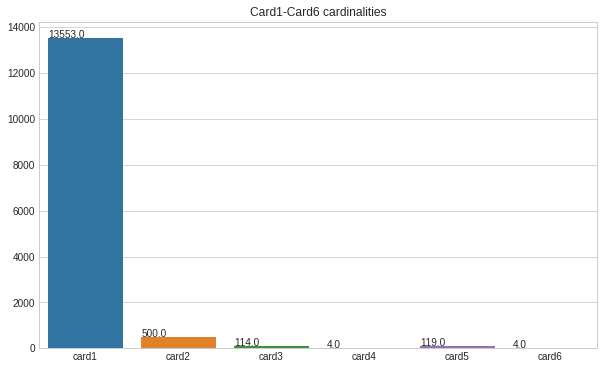

In [ ]:
cardx = [col for col in train_transaction.columns if col.startswith('card')]
cards = train_transaction[cardx]
plt.figure(figsize=(10,6))
ax = plt.axes()
sns.barplot(cards.nunique().index, cards.nunique().values)

for p in ax.patches:
    h = p.get_height()
    ax.text(p.get_x(), h+2, h)
ax.set(title='Card1-Card6 cardinalities')
plt.show()

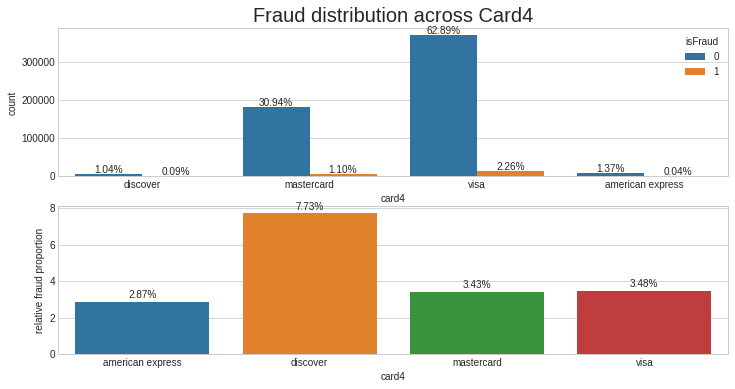

isFraud                0      1  relative fraud proportion
card4                                                     
american express    8089    239                       2.87
discover            6137    514                       7.73
mastercard        182721   6496                       3.43
visa              371394  13373                       3.48

In [ ]:
total = len(train_transaction)
ct = pd.crosstab(train_transaction.card4, train_transaction.isFraud)
ct['relative fraud proportion'] = round(100*(ct.iloc[:,1]/(ct.iloc[:,0]+ct.iloc[:,1])),2)
fig, (ax, ax1) = plt.subplots(2,1,figsize=(12,6))

sns.countplot(train_transaction.card4, hue=train_transaction.isFraud, ax=ax)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+3000,
            f'{height/total:.2%}',
            ha="center", fontsize=10)

ax.set_title('Fraud distribution across Card4',fontsize=20)

sns.barplot(ct.index, ct['relative fraud proportion'], ax=ax1)

for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x()+p.get_width()/2.,
            height+.2,
            f'{height}%',
            ha="center", fontsize=10)

plt.show()
ct

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


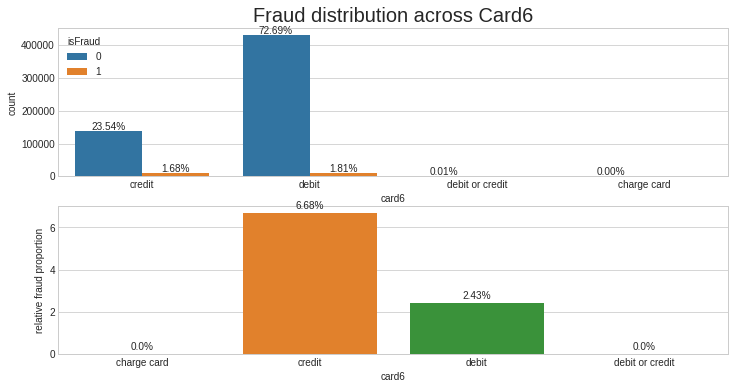

isFraud               0      1  relative fraud proportion
card6                                                    
charge card          15      0                       0.00
credit           139036   9950                       6.68
debit            429264  10674                       2.43
debit or credit      30      0                       0.00

In [ ]:
total = len(train_transaction)
ct = pd.crosstab(train_transaction.card6, train_transaction.isFraud)
ct['relative fraud proportion'] = round(100*(ct.iloc[:,1]/(ct.iloc[:,0]+ct.iloc[:,1])),2)
fig, (ax, ax1) = plt.subplots(2,1,figsize=(12,6))

sns.countplot(train_transaction.card6, hue=train_transaction.isFraud, ax=ax)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+3000,
            f'{height/total:.2%}',
            ha="center", fontsize=10)

ax.set_title('Fraud distribution across Card6',fontsize=20)

sns.barplot(ct.index, ct['relative fraud proportion'], ax=ax1)

for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x()+p.get_width()/2.,
            height+.2,
            f'{height}%',
            ha="center", fontsize=10)

plt.show()
ct

## M1-M9
match, such as names on card and address, etc.

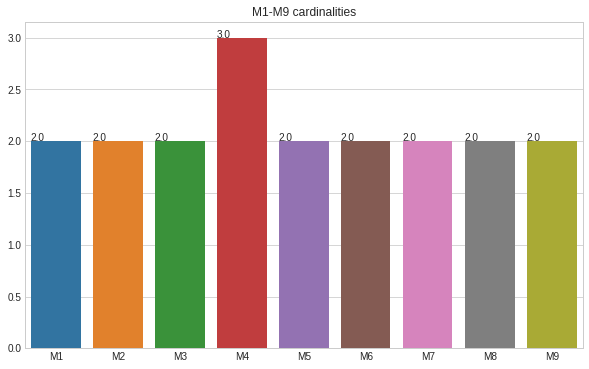

In [ ]:
mx = [col for col in train_transaction.columns if col.startswith('M')]
mxx = train_transaction[mx]
plt.figure(figsize=(10,6))
ax = plt.axes()
sns.barplot(mxx.nunique().index, mxx.nunique().values)

for p in ax.patches:
    h = p.get_height()
    ax.text(p.get_x(), h, h)
ax.set(title='M1-M9 cardinalities')
plt.show()

In [ ]:
train_transaction.M4.value_counts()

M0    196405
M2     59865
M1     52826
Name: M4, dtype: int64

In [ ]:
# check for duplicates
df = pd.DataFrame()
for col in mx:
  array, index = pd.factorize(mxx[col])
  df[col] = array

In [ ]:
df.T.duplicated().sum()

0

In [ ]:
# lets check correlation between Mx features using khi2
def is_feature_important(feature, target, alpha=.05):
    crosstable = pd.crosstab(target,feature) 
    chi2, p, dof, expected = stats.chi2_contingency(crosstable.values)
    
    return p < alpha

In [ ]:
from itertools import product
combinations = list(product(mx, mx))
correlation_matrix = pd.DataFrame()
for row, col in combinations:
  correlation_matrix.loc[row, col] = is_feature_important(mxx[row], mxx[col], alpha=0.01)

In [ ]:
correlation_matrix

M1    M2    M3     M4     M5     M6     M7     M8    M9
M1   True  True  True  False  False  False  False  False  True
M2   True  True  True   True   True   True   True   True  True
M3   True  True  True   True   True   True   True   True  True
M4  False  True  True   True   True   True   True  False  True
M5  False  True  True   True   True   True  False   True  True
M6  False  True  True   True   True   True   True   True  True
M7  False  True  True   True  False   True   True   True  True
M8  False  True  True  False   True   True   True   True  True
M9   True  True  True   True   True   True   True   True  True

In [ ]:
pd.crosstab(df.M9, df.M1)

M1      -1       0   1
M9                    
-1  270447   75785  20
 0     586   38042   4
 1      67  205588   1

## P_emaildomain & R_emaildomain

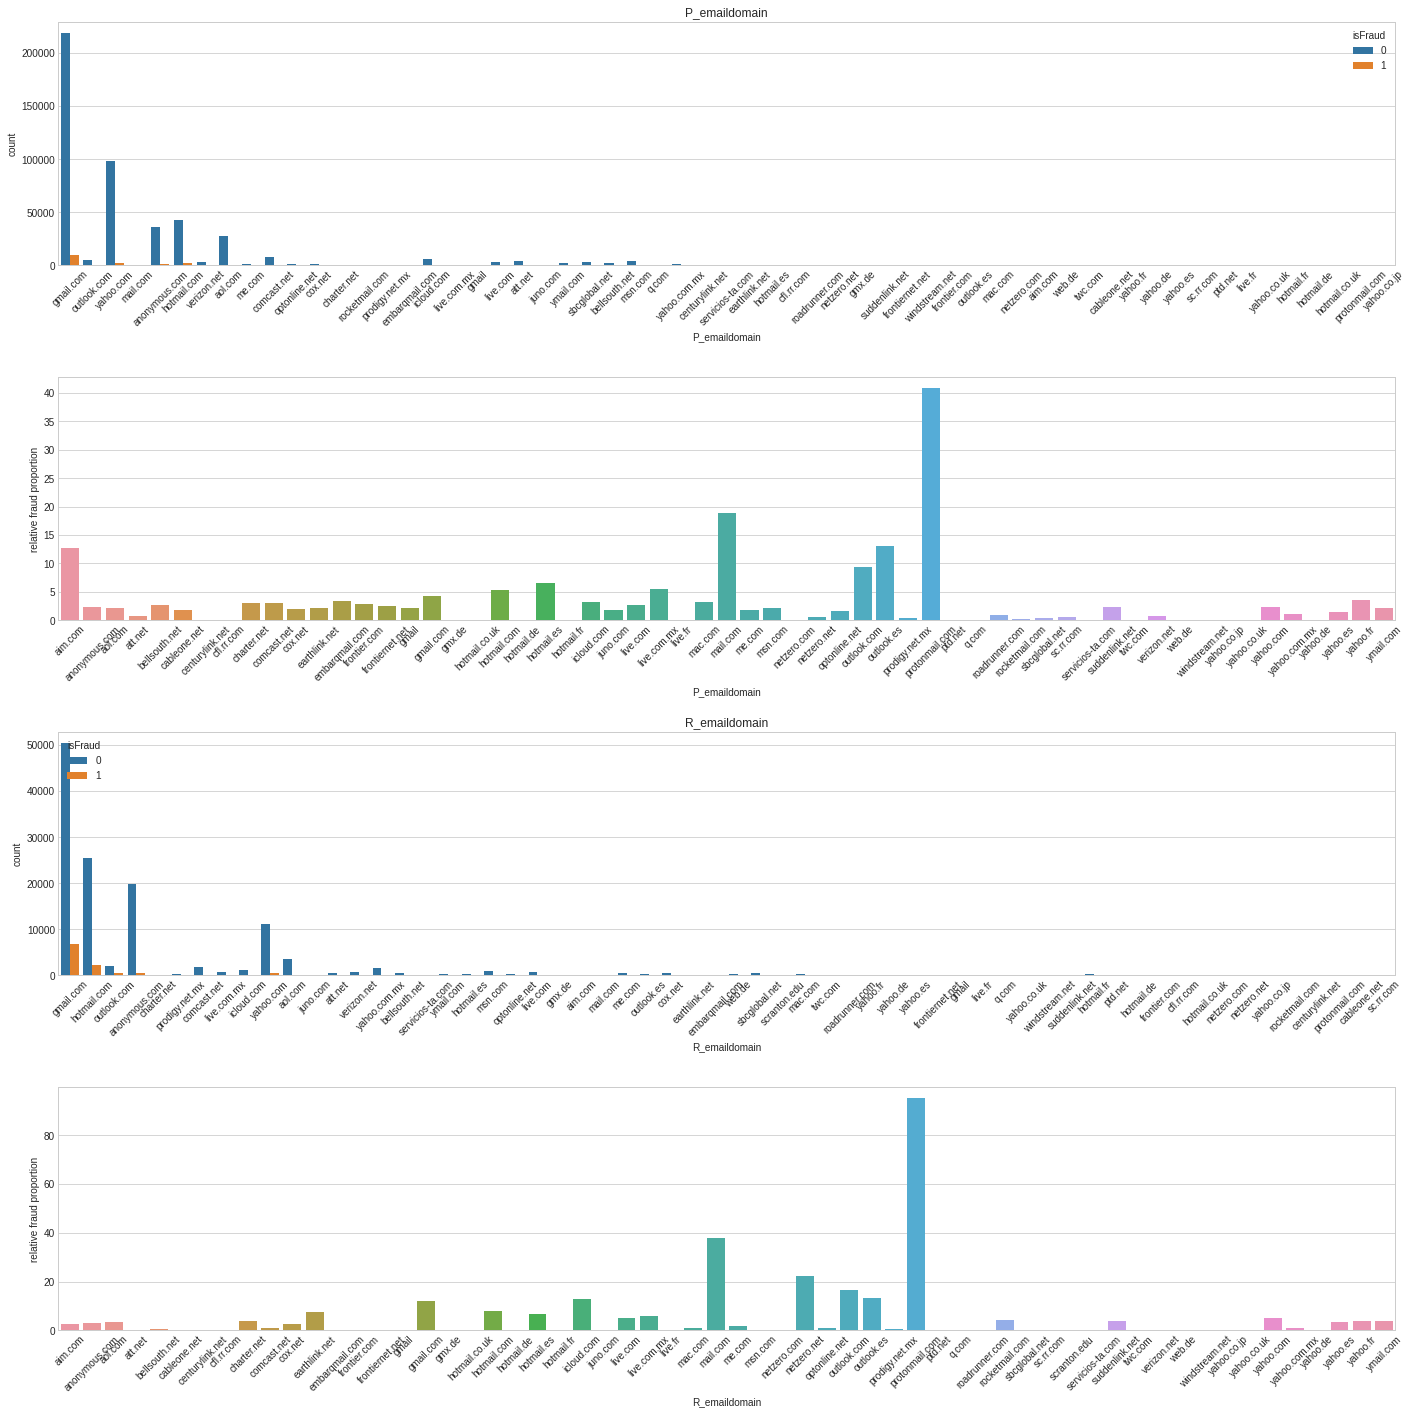

In [ ]:
fig = plt.figure(figsize=(20,20))

plt.subplot(4, 1, 1)
plt.title('P_emaildomain')
sns.countplot(train_transaction.P_emaildomain, hue=train_transaction.isFraud)
plt.xticks(rotation=45)


plt.subplot(4, 1, 2)
ct_p = pd.crosstab(train_transaction.P_emaildomain, train_transaction.isFraud)
ct_p['relative fraud proportion'] = round(100*(ct_p.iloc[:,1]/(ct_p.iloc[:,0]+ct_p.iloc[:,1])),2)
sns.barplot(ct_p.index, ct_p['relative fraud proportion'])
plt.xticks(rotation=45)

plt.subplot(4, 1, 3)
plt.title('R_emaildomain')
sns.countplot(train_transaction.R_emaildomain, hue=train_transaction.isFraud)
plt.xticks(rotation=45)

plt.subplot(4, 1, 4)
ct_r = pd.crosstab(train_transaction.R_emaildomain, train_transaction.isFraud)
ct_r['relative fraud proportion'] = round(100*(ct_r.iloc[:,1]/(ct_r.iloc[:,0]+ct_r.iloc[:,1])),2)
sns.barplot(ct_r.index, ct_r['relative fraud proportion'])
plt.xticks(rotation=45)


plt.tight_layout(pad=2.0)
plt.show()

# Identity table
lets check identity table features which is meanly composed of categorical variables (except TransactionID).

First let's check how many transactions have an equivalent row in identity table.

In [ ]:
train_transaction.TransactionID.isin(train_identity.TransactionID).sum()/len(train_transaction)

0.2442391709283029

In [ ]:
train_transaction[train_transaction.isFraud==1].TransactionID.isin(train_identity.TransactionID).sum()/len(train_transaction[train_transaction.isFraud==1])

0.5477423413831486

In [ ]:
train_transaction.isFraud.value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

24,42% of transactions are available in identity table out of which only 7.84% of transactions are fraudulent. **Identity table is very interesting since it describes 54,7% of fraudulent transactions(11318 out of 20663).**

Let us now merge identity table with transaction table

In [ ]:
train = pd.merge(train_transaction, train_identity, how='left', on='TransactionID')
test = pd.merge(test_transaction, test_identity, how='left', on='TransactionID')

# fix id-xx labels
for col in test.columns:
  if col.startswith('id'):
    test.rename(columns={col: col.replace('-', '_')}, inplace=True)

## id_0 to id_38

In [ ]:
id_xx = [col for col in train.columns if col.startswith('id')]
# check for duplicates
df = pd.DataFrame()
for col in id_xx:
  array, index = pd.factorize(train_identity[col])
  df[col] = array
  
f"{df.T.duplicated().sum()} duplicate columns"

'0 duplicate columns'

## DeviceType and DeviceInfo

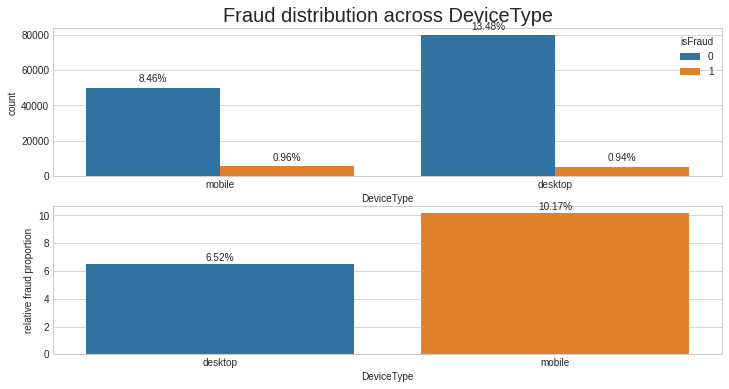

isFraud         0     1  relative fraud proportion
DeviceType                                        
desktop     79611  5554                       6.52
mobile      49988  5657                      10.17

In [ ]:
total = len(train)
ct = pd.crosstab(train.DeviceType, train.isFraud)
ct['relative fraud proportion'] = round(100*(ct.iloc[:,1]/(ct.iloc[:,0]+ct.iloc[:,1])),2)
fig, (ax, ax1) = plt.subplots(2,1,figsize=(12,6))

sns.countplot(train.DeviceType, hue=train.isFraud, ax=ax)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+3000,
            f'{height/total:.2%}',
            ha="center", fontsize=10)

ax.set_title('Fraud distribution across DeviceType',fontsize=20)

sns.barplot(ct.index, ct['relative fraud proportion'], ax=ax1)

for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x()+p.get_width()/2.,
            height+.2,
            f'{height}%',
            ha="center", fontsize=10)

plt.show()
ct

In [ ]:
ct = pd.crosstab(train.DeviceInfo, train.isFraud)
ct['relative fraud proportion'] = round(100*(ct.iloc[:,1]/(ct.iloc[:,0]+ct.iloc[:,1])),2)
ct.sort_values(by='relative fraud proportion')[ct['relative fraud proportion']>50]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


isFraud                        0   1  relative fraud proportion
DeviceInfo                                                     
F5121 Build/34.3.A.0.238      22  23                      51.11
E6603 Build/32.4.A.1.54       10  11                      52.38
SM-A720F Build/MMB29K          8   9                      52.94
moto x4 Build/OPWS27.57-40-6  15  17                      53.12
Hisense L675 Build/MRA58K     28  32                      53.33
...                           ..  ..                        ...
XT1609                         0   2                     100.00
SM-T285M                       0   1                     100.00
SM-T217S Build/KOT49H          0   4                     100.00
Mi                             0   2                     100.00
NX785QC8G                      0   1                     100.00

[107 rows x 3 columns]

# Data cleaning and feature engineering

In [ ]:
# drop highly correlated features

#vxx
train_cleaned = train.drop(columns=np.array(vxx_corr_pairs)[:,0])
test_cleaned = test.drop(columns=np.array(vxx_corr_pairs)[:,0])

#cxx
cxx_corr_pairs = get_corr_pairs(train_transaction[cxx])
train_cleaned = train_cleaned.drop(columns=np.array(cxx_corr_pairs)[:,0])
test_cleaned = test_cleaned.drop(columns=np.array(cxx_corr_pairs)[:,0])

#dxx
dxx_corr_pairs = get_corr_pairs(train_transaction[dxx])
train_cleaned = train_cleaned.drop(columns=np.array(dxx_corr_pairs)[:,0])
test_cleaned = test_cleaned.drop(columns=np.array(dxx_corr_pairs)[:,0])

# drop low variance (nearly constant variables)


# missing values imputation
for col in train_cleaned.drop(columns='isFraud').columns:
    if train_cleaned[col].dtype == np.int16 or train_cleaned[col].dtype == np.float16:
        train_cleaned[col] = train_cleaned[col].fillna(-9999) 
        test_cleaned[col] = test_cleaned[col].fillna(-9999)
    else:
        train_cleaned[col] = train_cleaned[col].fillna(-99999)
        test_cleaned[col] = test_cleaned[col].fillna(-99999) 


# create new variable to make the model look for daily patterns 
train_cleaned['TransactionDT'] = (train_cleaned.TransactionDT)%86400
train_cleaned['TransactionDT'] = (test_cleaned.TransactionDT)%86400

# Modeling

## Cross validation

In [ ]:
class CountEncoder(BaseEstimator):

    def __init__(self, normalize=True):
        self.normalize = normalize

    def fit(self, X_train, y=None):
        self.__set_mapping(X_train)
        
        return self

    def transform(self, X):
        X_tr = X.copy()

        if type(X) != type(pd.DataFrame()): 
            raise ValueError(f'{type(X)} not supported')
        
        col_id = 0
        for col, serie in  X.iteritems():
            X_tr[col] = serie.map(self.mapping_list[col_id])
            col_id += 1
        
        return X_tr

    def __set_mapping(self, X):
        if type(X) != type(pd.DataFrame()):
            raise ValueError(f'{type(X)} not supported')

        self.mapping_list = []
        for col, serie in X.iteritems():
            if self.normalize:
                self.mapping_list.append((serie.value_counts()/serie.value_counts().max()).to_dict())
            else:
                self.mapping_list.append(serie.value_counts().to_dict())

class BinningEncoder(BaseEstimator):

    def __init__(self, n_bins=4):
        self.n_bins = n_bins

    def fit(self, X_train, y=None):
        self.__set_bins(X_train)
        
        return self

    def transform(self, X):
        X_tr = X.copy()

        if type(X) != type(pd.DataFrame()): 
            raise ValueError(f'{type(X)} not supported')
        
        col_id = 0
        for col, serie in  X.iteritems():
            X_tr[col] = pd.cut(serie, bins=self.bins[col_id], labels=False, include_lowest=True)
            col_id += 1
        
        return X_tr

    def __set_bins(self, X):
        if type(X) != type(pd.DataFrame()):
            raise ValueError(f'{type(X)} not supported')

        self.bins = []
        for col, serie in X.iteritems():
            _, bins = pd.qcut(serie, self.n_bins, retbins=True, labels=False)
            self.bins.append(bins)

class MeanEncoder(BaseEstimator):
    '''
    TODO: ecrire la doc string
    '''
    def __init__(self, strategy='mean'):
        self.strategy = strategy

    def fit(self, X_train, y_train):
        # to be tested

        if type(X_train) != type(pd.DataFrame())  or type(y_train) != type(pd.Series()):
            raise ValueError(f'{type(X_train)} or {type(y_train)} not supported')
        
        self.__set_mapping(X_train, y_train)

        return self

    def transform(self, X):
        X_tr = X.copy()

        if type(X) != type(pd.DataFrame()):
            raise ValueError(f'{type(X)} not supported')
        
        col_id = 0
        for col, serie in  X.iteritems():
            X_tr[col] = serie.map(self.mapping_list[col_id])
            col_id += 1
        
        return X_tr

    def __set_mapping(self, X_train, y_train):
        '''
        TODO: ajouter docstring de la fonction
        
        ''' 

        self.mapping_list = []
        for col, serie in X_train.iteritems():
            self.mapping_list.append(y_train.groupby(serie).agg(self.strategy).to_dict())

In [ ]:
X_train = train_cleaned.drop(columns=['isFraud'])
y_train = train_cleaned.isFraud
X_test = test_cleaned

In [ ]:
static_params = {
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',
    'scale_pos_weight': 27.57
}

SEED = 42

# categorical variables
product = ['ProductCD'] 
email = ['P_emaildomain', 'R_emaildomain'] 
mx = [col for col in train_cleaned.columns if col.startswith('M')]
id_xx = [col for col in train_cleaned.columns if col.startswith('id')]
cardx = [col for col in train_cleaned.columns if col.startswith('card')]
addrx = [col for col in train_cleaned.columns if col.startswith('addr')]
device = ['DeviceInfo', 'DeviceType']
engineered_variables = ['TransactionDT']

# numerical variables
vxx = [col for col in train_cleaned.columns if col.startswith('V')]
distx = [col for col in train_cleaned.columns if col.startswith('dist')]
dxx = [col for col in train_cleaned.columns if col.startswith('D')]
cxx = [col for col in train_cleaned.columns if col.startswith('C')]


def my_pipeline(hps): 
    feature_engineering = ColumnTransformer([('target_encoder', MeanEncoder(), mx+email+product),
                                 ('count_encoder', CountEncoder(), device+addrx+cardx+id_xx),
                                 ('binning', BinningEncoder(n_bins=24), engineered_variables),
                                 ('pca', PCA(n_components = 0.8, random_state=SEED), vxx)],
                                 remainder='passthrough', verbose=1)
    
    steps = [('feature_engineering', feature_engineering),
             ('model', XGBClassifier(**static_params, **hps))
            ]

    model = Pipeline(steps)
    
    return model

hp_space = {
    'model': {        
        'max_depth': hp.choice('max_depth', range(6, 13)),
        'learning_rate': hp.loguniform('eta', -5*np.log(10), np.log(0.2)),
        'subsample': hp.uniform('subsample', 0.5, 1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    }
}

def objective_func(hps):
    model = my_pipeline(hps['model'])
    n_splits = 5
    timefolds = TimeSeriesSplit(n_splits = n_splits)
    score_sum = 0
    cv_id = 1
    print('----- new run -------------------------------------------')
    print('New parameters to be evaluated')
    print(hps)
    for train_index, val_index in timefolds.split(X_train):
        print(f'-------------- CV {cv_id}/{n_splits}---------------------')
        X_train_set, X_val_set = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_set, y_val_set = y_train.iloc[train_index], y_train.iloc[val_index]
       
        preprocessing = Pipeline(model.steps[:-1])
        preprocessing.fit(X_train_set, y_train_set)

        eval_set=[(preprocessing.transform(X_train_set), y_train_set), (preprocessing.transform(X_val_set), y_val_set)]

        model.fit(X_train_set, y_train_set,
                  model__early_stopping_rounds=10,
                  model__eval_set = eval_set,
                  model__eval_metric = 'auc'
        )
        score = roc_auc_score(y_val_set, model.predict_proba(X_val_set)[:, 1])
        score_sum += score
        cv_id += 1
        
        print(f'--------------- CV - AUC score: {round(score, 4)}-----------')   
    return -(score_sum / n_splits)

In [ ]:
trials = Trials()

best_clf1 = fmin(objective_func, 
                 hp_space, algo=tpe.suggest, max_evals=10, 
                 trials=trials, rstate=np.random.RandomState(SEED))

----- new run -------------------------------------------
New parameters to be evaluated
{'model': {'colsample_bytree': 0.543704347012368, 'learning_rate': 0.005510656109251953, 'max_depth': 8, 'subsample': 0.7273505261106861}}
-------------- CV 0/5---------------------
[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.2s
  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   0.7s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   0.5s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.2s
  0%|          | 0/10 [00:02<?, ?it/s, best loss: ?]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   0.7s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   0.5s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.868719	validation_1-auc:0.728292

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.899183	validation_1-auc:0.756388

[2]	validation_0-auc:0.916373	validation_1-auc:0.798456

[3]	validation_0-auc:0.919647	validation_1-auc:0.814723

[4]	validation_0-auc:0.925391	validation_1-auc:0.81918

[5]	validation_0-auc:0.925929	validation_1-auc:0.828928

[6]	validation_0-auc:0.927576	validation_1-auc:0.834419

[7]	validation_0-auc:0.9293	validation_1-auc:0.836726

[8]	validation_0-auc:0.929094	validation_1-auc:0.837056

[9]	validation_0-auc:0.92835	validation_1-auc:0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.3s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.3s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   1.3s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
  0%|          | 0/10 [00:10<?, ?it/s, best loss: ?]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.3s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.3s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   1.2s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.841766	validation_1-auc:0.754487

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.857983	validation_1-auc:0.756518

[2]	validation_0-auc:0.888162	validation_1-auc:0.804618

[3]	validation_0-auc:0.889282	validation_1-auc:0.823164

[4]	validation_0-auc:0.895183	validation_1-auc:0.833372

[5]	validation_0-auc:0.902346	validation_1-auc:0.842235

[6]	validation_0-auc:0.905396	validation_1-auc:0.852074

[7]	validation_0-auc:0.904312	validation_1-auc:0.856747

[8]	validation_0-auc:0.908132	

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.4s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.9s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.1s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
  0%|          | 0/10 [00:23<?, ?it/s, best loss: ?]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.4s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.9s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.0s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.85741	validation_1-auc:0.790152

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.876458	validation_1-auc:0.806597

[2]	validation_0-auc:0.894736	validation_1-auc:0.827959

[3]	validation_0-auc:0.89776	validation_1-auc:0.835809

[4]	validation_0-auc:0.9008	validation_1-auc:0.833823

[5]	validation_0-auc:0.904668	validation_1-auc:0.840947

[6]	validation_0-auc:0.905953	validation_1-auc:0.844859

[7]	validation_0-auc:0.907943	validation_1-auc:0.844289

[8]	validation_0-auc:0.909856	vali

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.5s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.5s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.8s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
  0%|          | 0/10 [00:42<?, ?it/s, best loss: ?]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.5s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.4s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.1s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.9s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.832182	validation_1-auc:0.778439

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.849833	validation_1-auc:0.815748

[2]	validation_0-auc:0.871176	validation_1-auc:0.833619

[3]	validation_0-auc:0.877896	validation_1-auc:0.837881

[4]	validation_0-auc:0.886312	validation_1-auc:0.841216

[5]	validation_0-auc:0.892438	validation_1-auc:0.850016

[6]	validation_0-auc:0.89329	validation_1-auc:0.853593

[7]	validation_0-auc:0.895096	validation_1-auc:0.852244

[8]	validation_0-auc:0.896962	v

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.7s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   3.3s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   3.7s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
  0%|          | 0/10 [01:06<?, ?it/s, best loss: ?]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.7s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.9s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   3.6s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.845126	validation_1-auc:0.799223

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.862632	validation_1-auc:0.822895

[2]	validation_0-auc:0.879325	validation_1-auc:0.842592

[3]	validation_0-auc:0.882087	validation_1-auc:0.844336

[4]	validation_0-auc:0.887241	validation_1-auc:0.845527

[5]	validation_0-auc:0.891496	validation_1-auc:0.850242

[6]	validation_0-auc:0.891979	validation_1-auc:0.853688

[7]	validation_0-auc:0.893708	validation_1-auc:0.853103

[8]	validation_0-auc:0.895085	

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.0s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   0.5s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.2s
 10%|█         | 1/10 [01:27<12:40, 84.54s/it, best loss: -0.861032798447005]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   0.7s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   0.6s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.883702	validation_1-auc:0.736237

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.914692	validation_1-auc:0.777356

[2]	validation_0-auc:0.932266	validation_1-auc:0.798612

[3]	validation_0-auc:0.93597	validation_1-auc:0.810643

[4]	validation_0-auc:0.939359	validation_1-auc:0.815676

[5]	validation_0-auc:0.942575	validation_1-auc:0.8176

[6]	validation_0-auc:0.945513	validation_1-auc:0.821624

[7]	validation_0-auc:0.945136	validation_1-auc:0.826158

[8]	validation_0-auc:0.947086	validation_1-auc:0.829685

[9]	validation_0-auc:0.947841	validation_1-auc:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.3s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.3s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   1.2s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 10%|█         | 1/10 [01:34<12:40, 84.54s/it, best loss: -0.861032798447005]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.3s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.3s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   1.3s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.863407	validation_1-auc:0.768445

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.893672	validation_1-auc:0.794243

[2]	validation_0-auc:0.911512	validation_1-auc:0.821247

[3]	validation_0-auc:0.915034	validation_1-auc:0.829545

[4]	validation_0-auc:0.924235	validation_1-auc:0.838434

[5]	validation_0-auc:0.927705	validation_1-auc:0.844189

[6]	validation_0-auc:0.929704	validation_1-auc:0.849304

[7]	validation_0-auc:0.930191	validation_1-auc:0.848504

[8]	validation_0-auc:0.931461	

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.4s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.2s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.1s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 10%|█         | 1/10 [01:49<12:40, 84.54s/it, best loss: -0.861032798447005]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.4s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.2s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.1s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.86525	validation_1-auc:0.800017

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.897439	validation_1-auc:0.820749

[2]	validation_0-auc:0.912461	validation_1-auc:0.838588

[3]	validation_0-auc:0.916709	validation_1-auc:0.8428

[4]	validation_0-auc:0.923486	validation_1-auc:0.844037

[5]	validation_0-auc:0.92618	validation_1-auc:0.848956

[6]	validation_0-auc:0.928239	validation_1-auc:0.852621

[7]	validation_0-auc:0.9302	validation_1-auc:0.853497

[8]	validation_0-auc:0.931078	valida

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.6s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.4s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.9s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 10%|█         | 1/10 [02:13<12:40, 84.54s/it, best loss: -0.861032798447005]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.5s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.4s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.9s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.864314	validation_1-auc:0.805599

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.889407	validation_1-auc:0.834767

[2]	validation_0-auc:0.904431	validation_1-auc:0.848854

[3]	validation_0-auc:0.907894	validation_1-auc:0.853509

[4]	validation_0-auc:0.914053	validation_1-auc:0.858306

[5]	validation_0-auc:0.91699	validation_1-auc:0.860726

[6]	validation_0-auc:0.918888	validation_1-auc:0.86237

[7]	validation_0-auc:0.920785	validation_1-auc:0.863561

[8]	validation_0-auc:0.921245	va

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.7s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.9s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   3.6s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 10%|█         | 1/10 [02:42<12:40, 84.54s/it, best loss: -0.861032798447005]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.7s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.9s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   3.6s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.861094	validation_1-auc:0.790592

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.883484	validation_1-auc:0.824464

[2]	validation_0-auc:0.898934	validation_1-auc:0.839004

[3]	validation_0-auc:0.903082	validation_1-auc:0.845433

[4]	validation_0-auc:0.909126	validation_1-auc:0.8492

[5]	validation_0-auc:0.91229	validation_1-auc:0.854469

[6]	validation_0-auc:0.914065	validation_1-auc:0.856029

[7]	validation_0-auc:0.916095	validation_1-auc:0.854406

[8]	validation_0-auc:0.916616	val

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.1s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   0.5s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.2s
 20%|██        | 2/10 [03:11<12:02, 90.28s/it, best loss: -0.8734464224260241]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   0.7s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   0.5s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.833957	validation_1-auc:0.767069

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.848667	validation_1-auc:0.783877

[2]	validation_0-auc:0.866152	validation_1-auc:0.802391

[3]	validation_0-auc:0.861401	validation_1-auc:0.804053

[4]	validation_0-auc:0.862298	validation_1-auc:0.797942

[5]	validation_0-auc:0.868588	validation_1-auc:0.800387

[6]	validation_0-auc:0.87422	validation_1-auc:0.80524

[7]	validation_0-auc:0.870824	validation_1-auc:0.802921

[8]	validation_0-auc:0.871274	validation_1-auc:0.79829

[9]	validation_0-auc:0.871853	validation_1-auc:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.3s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.3s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   1.3s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 20%|██        | 2/10 [03:17<12:02, 90.28s/it, best loss: -0.8734464224260241]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.3s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.3s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   1.2s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.832155	validation_1-auc:0.78392

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.851564	validation_1-auc:0.799067

[2]	validation_0-auc:0.86393	validation_1-auc:0.816579

[3]	validation_0-auc:0.864342	validation_1-auc:0.824547

[4]	validation_0-auc:0.866725	validation_1-auc:0.826679

[5]	validation_0-auc:0.86701	validation_1-auc:0.828044

[6]	validation_0-auc:0.869396	validation_1-auc:0.831594

[7]	validation_0-auc:0.869274	validation_1-auc:0.830218

[8]	validation_0-auc:0.868415	val

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.4s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.2s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.0s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 20%|██        | 2/10 [03:30<12:02, 90.28s/it, best loss: -0.8734464224260241]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.4s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.2s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.1s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.843551	validation_1-auc:0.787037

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.862715	validation_1-auc:0.805401

[2]	validation_0-auc:0.87249	validation_1-auc:0.818212

[3]	validation_0-auc:0.873939	validation_1-auc:0.822259

[4]	validation_0-auc:0.874512	validation_1-auc:0.823742

[5]	validation_0-auc:0.876198	validation_1-auc:0.826687

[6]	validation_0-auc:0.877958	validation_1-auc:0.83

[7]	validation_0-auc:0.878749	validation_1-auc:0.830924

[8]	validation_0-auc:0.87913	valida

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.5s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.4s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.9s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 20%|██        | 2/10 [03:48<12:02, 90.28s/it, best loss: -0.8734464224260241]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.6s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.4s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.9s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.813517	validation_1-auc:0.79196

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.844387	validation_1-auc:0.808617

[2]	validation_0-auc:0.858195	validation_1-auc:0.824998

[3]	validation_0-auc:0.861728	validation_1-auc:0.830442

[4]	validation_0-auc:0.862744	validation_1-auc:0.832585

[5]	validation_0-auc:0.863792	validation_1-auc:0.833088

[6]	validation_0-auc:0.864679	validation_1-auc:0.83666

[7]	validation_0-auc:0.86472	validation_1-auc:0.834775

[8]	validation_0-auc:0.864461	val

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.7s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.9s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   3.7s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 20%|██        | 2/10 [04:09<12:02, 90.28s/it, best loss: -0.8734464224260241]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.7s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   3.0s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   3.6s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.826706	validation_1-auc:0.809903

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.844287	validation_1-auc:0.816764

[2]	validation_0-auc:0.855597	validation_1-auc:0.827098

[3]	validation_0-auc:0.859015	validation_1-auc:0.831559

[4]	validation_0-auc:0.859796	validation_1-auc:0.832574

[5]	validation_0-auc:0.860757	validation_1-auc:0.833443

[6]	validation_0-auc:0.863786	validation_1-auc:0.836177

[7]	validation_0-auc:0.86366	validation_1-auc:0.835461

[8]	validation_0-auc:0.863486	v

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   0.7s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   0.5s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.2s
 30%|███       | 3/10 [04:32<10:12, 87.52s/it, best loss: -0.8734464224260241]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   0.8s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   0.5s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.863918	validation_1-auc:0.727781

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.895971	validation_1-auc:0.76085

[2]	validation_0-auc:0.915881	validation_1-auc:0.801645

[3]	validation_0-auc:0.919821	validation_1-auc:0.816241

[4]	validation_0-auc:0.924836	validation_1-auc:0.81924

[5]	validation_0-auc:0.927839	validation_1-auc:0.83066

[6]	validation_0-auc:0.929413	validation_1-auc:0.832798

[7]	validation_0-auc:0.930722	validation_1-auc:0.835817

[8]	validation_0-auc:0.930393	validation_1-auc:0.837058

[9]	validation_0-auc:0.929383	validation_1-auc:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.3s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.3s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   1.2s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 30%|███       | 3/10 [04:40<10:12, 87.52s/it, best loss: -0.8734464224260241]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.3s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.3s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   1.2s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.841666	validation_1-auc:0.752996

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.857646	validation_1-auc:0.755041

[2]	validation_0-auc:0.888585	validation_1-auc:0.802491

[3]	validation_0-auc:0.889043	validation_1-auc:0.823008

[4]	validation_0-auc:0.899024	validation_1-auc:0.833972

[5]	validation_0-auc:0.903602	validation_1-auc:0.841219

[6]	validation_0-auc:0.907119	validation_1-auc:0.850208

[7]	validation_0-auc:0.90543	validation_1-auc:0.854518

[8]	validation_0-auc:0.908562	v

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.4s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.2s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.0s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 30%|███       | 3/10 [04:52<10:12, 87.52s/it, best loss: -0.8734464224260241]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.4s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.2s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.0s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.857252	validation_1-auc:0.791063

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.875784	validation_1-auc:0.804021

[2]	validation_0-auc:0.894592	validation_1-auc:0.827243

[3]	validation_0-auc:0.897543	validation_1-auc:0.834971

[4]	validation_0-auc:0.905176	validation_1-auc:0.836964

[5]	validation_0-auc:0.907517	validation_1-auc:0.84366

[6]	validation_0-auc:0.908592	validation_1-auc:0.846034

[7]	validation_0-auc:0.909474	validation_1-auc:0.844361

[8]	validation_0-auc:0.910579	v

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.5s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.4s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.9s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 30%|███       | 3/10 [05:11<10:12, 87.52s/it, best loss: -0.8734464224260241]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.5s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.4s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.9s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.833248	validation_1-auc:0.776375

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.849694	validation_1-auc:0.814108

[2]	validation_0-auc:0.871321	validation_1-auc:0.832321

[3]	validation_0-auc:0.876921	validation_1-auc:0.836319

[4]	validation_0-auc:0.887555	validation_1-auc:0.847276

[5]	validation_0-auc:0.893542	validation_1-auc:0.854358

[6]	validation_0-auc:0.894741	validation_1-auc:0.855581

[7]	validation_0-auc:0.895766	validation_1-auc:0.853313

[8]	validation_0-auc:0.896198	

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.7s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.9s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   3.7s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 30%|███       | 3/10 [05:33<10:12, 87.52s/it, best loss: -0.8734464224260241]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.7s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   3.0s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   3.7s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.845393	validation_1-auc:0.801608

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.862822	validation_1-auc:0.824252

[2]	validation_0-auc:0.87963	validation_1-auc:0.842476

[3]	validation_0-auc:0.882339	validation_1-auc:0.844608

[4]	validation_0-auc:0.889621	validation_1-auc:0.847829

[5]	validation_0-auc:0.893223	validation_1-auc:0.850611

[6]	validation_0-auc:0.893913	validation_1-auc:0.853894

[7]	validation_0-auc:0.894518	validation_1-auc:0.851811

[8]	validation_0-auc:0.895356	v

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   0.7s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   0.5s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.2s
 40%|████      | 4/10 [05:54<08:35, 85.95s/it, best loss: -0.8734464224260241]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   0.7s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   0.5s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.939026	validation_1-auc:0.611079

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.958452	validation_1-auc:0.707288

[2]	validation_0-auc:0.970094	validation_1-auc:0.724614

[3]	validation_0-auc:0.970363	validation_1-auc:0.734827

[4]	validation_0-auc:0.972786	validation_1-auc:0.739298

[5]	validation_0-auc:0.973045	validation_1-auc:0.741274

[6]	validation_0-auc:0.97559	validation_1-auc:0.747405

[7]	validation_0-auc:0.976073	validation_1-auc:0.747238

[8]	validation_0-auc:0.975933	validation_1-auc:0.748198

[9]	validation_0-auc:0.976068	validation_1-au

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.3s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.6s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   1.3s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 40%|████      | 4/10 [06:02<08:35, 85.95s/it, best loss: -0.8734464224260241]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.3s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.3s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   1.3s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.935081	validation_1-auc:0.770022

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.946227	validation_1-auc:0.783826

[2]	validation_0-auc:0.961135	validation_1-auc:0.798221

[3]	validation_0-auc:0.962456	validation_1-auc:0.802844

[4]	validation_0-auc:0.963508	validation_1-auc:0.805069

[5]	validation_0-auc:0.964061	validation_1-auc:0.805171

[6]	validation_0-auc:0.964658	validation_1-auc:0.807773

[7]	validation_0-auc:0.965229	validation_1-auc:0.81105

[8]	validation_0-auc:0.965543	v

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.4s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.9s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.1s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 40%|████      | 4/10 [06:20<08:35, 85.95s/it, best loss: -0.8734464224260241]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.4s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.2s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.0s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.939944	validation_1-auc:0.760881

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.951403	validation_1-auc:0.789765

[2]	validation_0-auc:0.960228	validation_1-auc:0.805921

[3]	validation_0-auc:0.963308	validation_1-auc:0.810221

[4]	validation_0-auc:0.964799	validation_1-auc:0.809392

[5]	validation_0-auc:0.965664	validation_1-auc:0.822681

[6]	validation_0-auc:0.966515	validation_1-auc:0.816889

[7]	validation_0-auc:0.967007	validation_1-auc:0.818147

[8]	validation_0-auc:0.967513	

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.5s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.4s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.9s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 40%|████      | 4/10 [06:39<08:35, 85.95s/it, best loss: -0.8734464224260241]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.5s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.4s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.9s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.925745	validation_1-auc:0.762245

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.946502	validation_1-auc:0.797984

[2]	validation_0-auc:0.952938	validation_1-auc:0.802276

[3]	validation_0-auc:0.954187	validation_1-auc:0.807059

[4]	validation_0-auc:0.954972	validation_1-auc:0.817199

[5]	validation_0-auc:0.955991	validation_1-auc:0.822115

[6]	validation_0-auc:0.956437	validation_1-auc:0.822053

[7]	validation_0-auc:0.957383	validation_1-auc:0.822762

[8]	validation_0-auc:0.957224	

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.7s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   3.0s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   3.7s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 40%|████      | 4/10 [07:13<08:35, 85.95s/it, best loss: -0.8734464224260241]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.7s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   3.0s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   3.7s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.927724	validation_1-auc:0.775789

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.939777	validation_1-auc:0.798598

[2]	validation_0-auc:0.945803	validation_1-auc:0.811032

[3]	validation_0-auc:0.949159	validation_1-auc:0.818682

[4]	validation_0-auc:0.9502	validation_1-auc:0.81745

[5]	validation_0-auc:0.950595	validation_1-auc:0.821871

[6]	validation_0-auc:0.951092	validation_1-auc:0.822307

[7]	validation_0-auc:0.951246	validation_1-auc:0.822027

[8]	validation_0-auc:0.951647	val

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   0.7s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   0.5s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.2s
 50%|█████     | 5/10 [07:34<07:30, 90.19s/it, best loss: -0.8734464224260241]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   0.8s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   0.6s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.860616	validation_1-auc:0.749262

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.869125	validation_1-auc:0.771361

[2]	validation_0-auc:0.887159	validation_1-auc:0.795396

[3]	validation_0-auc:0.885579	validation_1-auc:0.802752

[4]	validation_0-auc:0.886825	validation_1-auc:0.799104

[5]	validation_0-auc:0.890236	validation_1-auc:0.799246

[6]	validation_0-auc:0.89457	validation_1-auc:0.805768

[7]	validation_0-auc:0.893244	validation_1-auc:0.808122

[8]	validation_0-auc:0.891774	validation_1-auc:0.808387

[9]	validation_0-auc:0.89163	validation_1-auc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.3s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.7s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   1.3s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 50%|█████     | 5/10 [07:41<07:30, 90.19s/it, best loss: -0.8734464224260241]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.3s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.3s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   1.3s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.858597	validation_1-auc:0.807105

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.875217	validation_1-auc:0.820736

[2]	validation_0-auc:0.885364	validation_1-auc:0.829452

[3]	validation_0-auc:0.884928	validation_1-auc:0.832592

[4]	validation_0-auc:0.886944	validation_1-auc:0.834173

[5]	validation_0-auc:0.886736	validation_1-auc:0.833846

[6]	validation_0-auc:0.887691	validation_1-auc:0.835154

[7]	validation_0-auc:0.887201	validation_1-auc:0.834004

[8]	validation_0-auc:0.887507	

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.4s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.9s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.1s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 50%|█████     | 5/10 [07:54<07:30, 90.19s/it, best loss: -0.8734464224260241]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.4s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.2s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.1s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.867357	validation_1-auc:0.799016

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.888138	validation_1-auc:0.825592

[2]	validation_0-auc:0.892457	validation_1-auc:0.834538

[3]	validation_0-auc:0.89135	validation_1-auc:0.834378

[4]	validation_0-auc:0.893268	validation_1-auc:0.83333

[5]	validation_0-auc:0.894743	validation_1-auc:0.835823

[6]	validation_0-auc:0.895435	validation_1-auc:0.838333

[7]	validation_0-auc:0.895987	validation_1-auc:0.837046

[8]	validation_0-auc:0.896448	va

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.6s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.5s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.9s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 50%|█████     | 5/10 [08:10<07:30, 90.19s/it, best loss: -0.8734464224260241]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.6s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.4s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.9s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.849608	validation_1-auc:0.813784

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.873367	validation_1-auc:0.831235

[2]	validation_0-auc:0.880518	validation_1-auc:0.839619

[3]	validation_0-auc:0.879298	validation_1-auc:0.839642

[4]	validation_0-auc:0.880135	validation_1-auc:0.841999

[5]	validation_0-auc:0.881313	validation_1-auc:0.842302

[6]	validation_0-auc:0.882474	validation_1-auc:0.842571

[7]	validation_0-auc:0.883352	validation_1-auc:0.843856

[8]	validation_0-auc:0.883512	

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.7s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   3.0s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   3.8s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 50%|█████     | 5/10 [08:31<07:30, 90.19s/it, best loss: -0.8734464224260241]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.7s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   3.0s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   3.8s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.856441	validation_1-auc:0.816999

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.872183	validation_1-auc:0.831984

[2]	validation_0-auc:0.875755	validation_1-auc:0.836037

[3]	validation_0-auc:0.877539	validation_1-auc:0.835969

[4]	validation_0-auc:0.878645	validation_1-auc:0.839635

[5]	validation_0-auc:0.879798	validation_1-auc:0.840489

[6]	validation_0-auc:0.881646	validation_1-auc:0.844095

[7]	validation_0-auc:0.882394	validation_1-auc:0.845137

[8]	validation_0-auc:0.882247	

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   0.7s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   0.6s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.2s
 60%|██████    | 6/10 [08:52<05:46, 86.52s/it, best loss: -0.8734464224260241]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   0.7s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   0.5s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.898233	validation_1-auc:0.723928

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.919561	validation_1-auc:0.772655

[2]	validation_0-auc:0.934468	validation_1-auc:0.788051

[3]	validation_0-auc:0.938289	validation_1-auc:0.805591

[4]	validation_0-auc:0.941393	validation_1-auc:0.797371

[5]	validation_0-auc:0.942757	validation_1-auc:0.792597

[6]	validation_0-auc:0.946498	validation_1-auc:0.79259

[7]	validation_0-auc:0.947762	validation_1-auc:0.79623

[8]	validation_0-auc:0.948011	validation_1-auc:0.801649

[9]	validation_0-auc:0.949647	validation_1-auc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.3s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.3s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   1.3s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 60%|██████    | 6/10 [08:59<05:46, 86.52s/it, best loss: -0.8734464224260241]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.3s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.3s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   1.3s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.891009	validation_1-auc:0.782775

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.914863	validation_1-auc:0.806247

[2]	validation_0-auc:0.925401	validation_1-auc:0.833423

[3]	validation_0-auc:0.926183	validation_1-auc:0.841325

[4]	validation_0-auc:0.92927	validation_1-auc:0.845076

[5]	validation_0-auc:0.93286	validation_1-auc:0.848816

[6]	validation_0-auc:0.93468	validation_1-auc:0.850279

[7]	validation_0-auc:0.937391	validation_1-auc:0.854459

[8]	validation_0-auc:0.938932	val

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.4s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.9s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.1s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 60%|██████    | 6/10 [09:13<05:46, 86.52s/it, best loss: -0.8734464224260241]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.4s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.9s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.1s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.892013	validation_1-auc:0.780982

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.920645	validation_1-auc:0.82144

[2]	validation_0-auc:0.924203	validation_1-auc:0.834913

[3]	validation_0-auc:0.926336	validation_1-auc:0.839521

[4]	validation_0-auc:0.932871	validation_1-auc:0.844145

[5]	validation_0-auc:0.936652	validation_1-auc:0.847558

[6]	validation_0-auc:0.938736	validation_1-auc:0.849807

[7]	validation_0-auc:0.939544	validation_1-auc:0.85065

[8]	validation_0-auc:0.942254	va

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.5s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.8s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.9s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 60%|██████    | 6/10 [09:34<05:46, 86.52s/it, best loss: -0.8734464224260241]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.6s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.7s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.9s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.882693	validation_1-auc:0.80368

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.906243	validation_1-auc:0.834383

[2]	validation_0-auc:0.915443	validation_1-auc:0.843908

[3]	validation_0-auc:0.916962	validation_1-auc:0.848289

[4]	validation_0-auc:0.92249	validation_1-auc:0.853927

[5]	validation_0-auc:0.924721	validation_1-auc:0.854285

[6]	validation_0-auc:0.927496	validation_1-auc:0.856147

[7]	validation_0-auc:0.928596	validation_1-auc:0.857038

[8]	validation_0-auc:0.930563	va

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.7s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   3.0s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   3.8s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 60%|██████    | 6/10 [10:01<05:46, 86.52s/it, best loss: -0.8734464224260241]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.7s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   3.0s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   3.8s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.882598	validation_1-auc:0.799665

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.905944	validation_1-auc:0.827722

[2]	validation_0-auc:0.911198	validation_1-auc:0.838892

[3]	validation_0-auc:0.913088	validation_1-auc:0.844719

[4]	validation_0-auc:0.915408	validation_1-auc:0.847504

[5]	validation_0-auc:0.918537	validation_1-auc:0.849956

[6]	validation_0-auc:0.922411	validation_1-auc:0.852741

[7]	validation_0-auc:0.923771	validation_1-auc:0.853345

[8]	validation_0-auc:0.926514	

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   0.8s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   0.5s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.2s
 70%|███████   | 7/10 [10:26<04:25, 88.59s/it, best loss: -0.8734464224260241]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   0.7s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   0.6s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.924654	validation_1-auc:0.686843

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.948618	validation_1-auc:0.716523

[2]	validation_0-auc:0.963966	validation_1-auc:0.760541

[3]	validation_0-auc:0.967003	validation_1-auc:0.784226

[4]	validation_0-auc:0.972221	validation_1-auc:0.788201

[5]	validation_0-auc:0.975031	validation_1-auc:0.797757

[6]	validation_0-auc:0.977442	validation_1-auc:0.799446

[7]	validation_0-auc:0.979011	validation_1-auc:0.803588

[8]	validation_0-auc:0.978297	validation_1-auc:0.812245

[9]	validation_0-auc:0.978147	validation_1-a

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.3s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.6s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   1.3s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 70%|███████   | 7/10 [10:37<04:25, 88.59s/it, best loss: -0.8734464224260241]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.3s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.3s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   1.3s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.905481	validation_1-auc:0.717689

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.927334	validation_1-auc:0.753224

[2]	validation_0-auc:0.951603	validation_1-auc:0.794542

[3]	validation_0-auc:0.954877	validation_1-auc:0.813071

[4]	validation_0-auc:0.964536	validation_1-auc:0.824489

[5]	validation_0-auc:0.968003	validation_1-auc:0.840674

[6]	validation_0-auc:0.969321	validation_1-auc:0.842756

[7]	validation_0-auc:0.969439	validation_1-auc:0.845333

[8]	validation_0-auc:0.968908	

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.4s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.9s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.0s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 70%|███████   | 7/10 [10:56<04:25, 88.59s/it, best loss: -0.8734464224260241]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.4s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.9s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.0s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.916011	validation_1-auc:0.773432

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.938073	validation_1-auc:0.797813

[2]	validation_0-auc:0.951433	validation_1-auc:0.82358

[3]	validation_0-auc:0.953125	validation_1-auc:0.835539

[4]	validation_0-auc:0.961689	validation_1-auc:0.846067

[5]	validation_0-auc:0.964626	validation_1-auc:0.854044

[6]	validation_0-auc:0.965013	validation_1-auc:0.856243

[7]	validation_0-auc:0.966032	validation_1-auc:0.859326

[8]	validation_0-auc:0.966115	v

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.5s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.5s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.9s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 70%|███████   | 7/10 [11:17<04:25, 88.59s/it, best loss: -0.8734464224260241]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.5s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.7s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.8s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.897512	validation_1-auc:0.764656

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.913595	validation_1-auc:0.81078

[2]	validation_0-auc:0.933995	validation_1-auc:0.839192

[3]	validation_0-auc:0.93666	validation_1-auc:0.850847

[4]	validation_0-auc:0.945719	validation_1-auc:0.859564

[5]	validation_0-auc:0.950233	validation_1-auc:0.863553

[6]	validation_0-auc:0.952124	validation_1-auc:0.867372

[7]	validation_0-auc:0.953328	validation_1-auc:0.865458

[8]	validation_0-auc:0.952938	va

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.7s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   3.0s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   3.7s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 70%|███████   | 7/10 [11:44<04:25, 88.59s/it, best loss: -0.8734464224260241]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.7s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   3.0s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   3.8s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.89386	validation_1-auc:0.759627

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.912109	validation_1-auc:0.800602

[2]	validation_0-auc:0.931923	validation_1-auc:0.823981

[3]	validation_0-auc:0.93566	validation_1-auc:0.8357

[4]	validation_0-auc:0.944278	validation_1-auc:0.844695

[5]	validation_0-auc:0.949101	validation_1-auc:0.855838

[6]	validation_0-auc:0.949673	validation_1-auc:0.857677

[7]	validation_0-auc:0.951306	validation_1-auc:0.862154

[8]	validation_0-auc:0.951675	vali

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   0.7s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   0.5s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.2s
 80%|████████  | 8/10 [12:12<03:07, 93.75s/it, best loss: -0.8766373215912744]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   0.7s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   0.5s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.88795	validation_1-auc:0.685101

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.909883	validation_1-auc:0.708433

[2]	validation_0-auc:0.93532	validation_1-auc:0.740556

[3]	validation_0-auc:0.935012	validation_1-auc:0.748021

[4]	validation_0-auc:0.937149	validation_1-auc:0.76434

[5]	validation_0-auc:0.937301	validation_1-auc:0.781478

[6]	validation_0-auc:0.937156	validation_1-auc:0.782593

[7]	validation_0-auc:0.937236	validation_1-auc:0.783709

[8]	validation_0-auc:0.937225	validation_1-auc:0.78311

[9]	validation_0-auc:0.940963	validation_1-auc:0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.3s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.3s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   1.3s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 80%|████████  | 8/10 [12:19<03:07, 93.75s/it, best loss: -0.8766373215912744]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.3s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.6s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   1.3s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.891827	validation_1-auc:0.737722

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.912858	validation_1-auc:0.758991

[2]	validation_0-auc:0.923713	validation_1-auc:0.779762

[3]	validation_0-auc:0.926351	validation_1-auc:0.787246

[4]	validation_0-auc:0.928694	validation_1-auc:0.78714

[5]	validation_0-auc:0.932604	validation_1-auc:0.795872

[6]	validation_0-auc:0.934392	validation_1-auc:0.808499

[7]	validation_0-auc:0.934466	validation_1-auc:0.810779

[8]	validation_0-auc:0.934279	v

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.4s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.9s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.1s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 80%|████████  | 8/10 [12:33<03:07, 93.75s/it, best loss: -0.8766373215912744]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.4s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.9s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.1s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.906119	validation_1-auc:0.764206

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.921498	validation_1-auc:0.781665

[2]	validation_0-auc:0.929661	validation_1-auc:0.788148

[3]	validation_0-auc:0.934698	validation_1-auc:0.811783

[4]	validation_0-auc:0.936936	validation_1-auc:0.821123

[5]	validation_0-auc:0.938445	validation_1-auc:0.828848

[6]	validation_0-auc:0.939974	validation_1-auc:0.832893

[7]	validation_0-auc:0.940601	validation_1-auc:0.834628

[8]	validation_0-auc:0.941895	

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.5s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.8s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   3.0s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 80%|████████  | 8/10 [12:51<03:07, 93.75s/it, best loss: -0.8766373215912744]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.6s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.8s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.9s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.904232	validation_1-auc:0.775861

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.917169	validation_1-auc:0.809726

[2]	validation_0-auc:0.92234	validation_1-auc:0.828871

[3]	validation_0-auc:0.924805	validation_1-auc:0.835617

[4]	validation_0-auc:0.925844	validation_1-auc:0.838627

[5]	validation_0-auc:0.926211	validation_1-auc:0.837807

[6]	validation_0-auc:0.92809	validation_1-auc:0.838112

[7]	validation_0-auc:0.928702	validation_1-auc:0.839989

[8]	validation_0-auc:0.929681	va

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.7s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   3.1s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.1s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   3.8s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 80%|████████  | 8/10 [13:21<03:07, 93.75s/it, best loss: -0.8766373215912744]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.7s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   3.1s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   3.9s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.897529	validation_1-auc:0.778953

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.910541	validation_1-auc:0.80718

[2]	validation_0-auc:0.918036	validation_1-auc:0.81231

[3]	validation_0-auc:0.920977	validation_1-auc:0.816021

[4]	validation_0-auc:0.922261	validation_1-auc:0.81991

[5]	validation_0-auc:0.923217	validation_1-auc:0.821925

[6]	validation_0-auc:0.92383	validation_1-auc:0.830189

[7]	validation_0-auc:0.924085	validation_1-auc:0.830379

[8]	validation_0-auc:0.924182	vali

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   0.7s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   0.5s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.2s
 90%|█████████ | 9/10 [13:48<01:34, 94.72s/it, best loss: -0.8766373215912744]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   0.7s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   0.5s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.858609	validation_1-auc:0.76869

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.868405	validation_1-auc:0.784078

[2]	validation_0-auc:0.888693	validation_1-auc:0.80285

[3]	validation_0-auc:0.891863	validation_1-auc:0.813264

[4]	validation_0-auc:0.895145	validation_1-auc:0.815395

[5]	validation_0-auc:0.895144	validation_1-auc:0.819462

[6]	validation_0-auc:0.899863	validation_1-auc:0.822011

[7]	validation_0-auc:0.897457	validation_1-auc:0.822558

[8]	validation_0-auc:0.897227	validation_1-auc:0.818083

[9]	validation_0-auc:0.898067	validation_1-auc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.3s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.3s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   1.3s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 90%|█████████ | 9/10 [13:55<01:34, 94.72s/it, best loss: -0.8766373215912744]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.3s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.7s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   1.3s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.852345	validation_1-auc:0.791668

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.861907	validation_1-auc:0.798328

[2]	validation_0-auc:0.878111	validation_1-auc:0.818344

[3]	validation_0-auc:0.882571	validation_1-auc:0.822527

[4]	validation_0-auc:0.887521	validation_1-auc:0.83032

[5]	validation_0-auc:0.886998	validation_1-auc:0.832744

[6]	validation_0-auc:0.891468	validation_1-auc:0.841501

[7]	validation_0-auc:0.890591	validation_1-auc:0.840912

[8]	validation_0-auc:0.891764	v

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.4s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.9s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.0s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 90%|█████████ | 9/10 [14:08<01:34, 94.72s/it, best loss: -0.8766373215912744]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.4s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   1.9s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.0s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.857022	validation_1-auc:0.795177

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.874987	validation_1-auc:0.813254

[2]	validation_0-auc:0.886425	validation_1-auc:0.828764

[3]	validation_0-auc:0.888494	validation_1-auc:0.832159

[4]	validation_0-auc:0.890409	validation_1-auc:0.831966

[5]	validation_0-auc:0.890448	validation_1-auc:0.831297

[6]	validation_0-auc:0.89362	validation_1-auc:0.834557

[7]	validation_0-auc:0.894095	validation_1-auc:0.833607

[8]	validation_0-auc:0.895223	v

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.5s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.8s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   3.0s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 90%|█████████ | 9/10 [14:26<01:34, 94.72s/it, best loss: -0.8766373215912744]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.5s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   2.7s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   2.8s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.835068	validation_1-auc:0.807079

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.849056	validation_1-auc:0.817825

[2]	validation_0-auc:0.869919	validation_1-auc:0.837132

[3]	validation_0-auc:0.874372	validation_1-auc:0.842188

[4]	validation_0-auc:0.877098	validation_1-auc:0.842789

[5]	validation_0-auc:0.876974	validation_1-auc:0.842237

[6]	validation_0-auc:0.879154	validation_1-auc:0.845263

[7]	validation_0-auc:0.878931	validation_1-auc:0.84341

[8]	validation_0-auc:0.878969	v

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.7s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   3.0s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   3.7s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
 90%|█████████ | 9/10 [14:49<01:34, 94.72s/it, best loss: -0.8766373215912744]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.7s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   3.0s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.0s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   3.8s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[0]	validation_0-auc:0.841709	validation_1-auc:0.8079

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 10 rounds.

[1]	validation_0-auc:0.849942	validation_1-auc:0.811823

[2]	validation_0-auc:0.868454	validation_1-auc:0.83068

[3]	validation_0-auc:0.873297	validation_1-auc:0.838489

[4]	validation_0-auc:0.876033	validation_1-auc:0.838858

[5]	validation_0-auc:0.878527	validation_1-auc:0.84385

[6]	validation_0-auc:0.881732	validation_1-auc:0.846608

[7]	validation_0-auc:0.882371	validation_1-auc:0.846206

[8]	validation_0-auc:0.883077	vali

In [ ]:
print('Best parameters:')
best_params = space_eval(hp_space, best_clf1)
print(best_params)

Best parameters:
{'model': {'colsample_bytree': 0.6111947591391402, 'learning_rate': 0.00019207417999056814, 'max_depth': 12, 'subsample': 0.8085396792511581}}


## Training the final model

In [ ]:
model = my_pipeline(best_params['model'])
model.fit(X_train, y_train)

ypred = model.predict_proba(X_test)[:,1] 

sample_submission = pd.read_csv('sample_submission.csv', index_col='TransactionID')
sample_submission['isFraud'] = ypred
sample_submission.to_csv('fraud_detection_xgb.csv')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


[ColumnTransformer]  (1 of 5) Processing target_encoder, total=   0.8s
[ColumnTransformer] . (2 of 5) Processing count_encoder, total=   3.9s
[ColumnTransformer] ....... (3 of 5) Processing binning, total=   0.1s
[ColumnTransformer] ........... (4 of 5) Processing pca, total=   4.6s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s


In [ ]:
!kaggle competitions submit -c ieee-fraud-detection -f fraud_detection_xgb.csv -m "my submission"

100% 9.01M/9.01M [00:03<00:00, 3.07MB/s]
Successfully submitted to IEEE-CIS Fraud Detection